## Project: Stock Market K-means and Agglomerative Clustering Analysis of data for  340 companies

## Importing necessary libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from scipy.stats import zscore
import seaborn as sns

In [2]:
# to scale the data using z-score
from sklearn.preprocessing import StandardScaler
# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

In [3]:

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## What kind of data are we dealing with:

Data Dictionary

Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market

Company: Name of the company

GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations

GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations

Current Price: Current stock price in dollars

Price Change: Percentage change in the stock price in 13 weeks

Volatility: Standard deviation of the stock price over the past 13 weeks

ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)

Cash Ratio: The ratio of a company's total reserves of cash and cash equivalents to its total current liabilities

Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)

Net Income: Revenues minus expenses, interest, and taxes (in dollars)

Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)

Estimated Shares Outstanding: Company's stock currently held by all its shareholders

P/E Ratio: Ratio of the company's current stock price to the earnings per share

P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)


In [429]:
# reading the CSV file into pandas dataframe
data = pd.read_csv("stock_data.csv") 
data.head(10)

Ticker Symbol                   Security             GICS Sector  \
0           AAL    American Airlines Group             Industrials   
1          ABBV                     AbbVie             Health Care   
2           ABT        Abbott Laboratories             Health Care   
3          ADBE          Adobe Systems Inc  Information Technology   
4           ADI       Analog Devices, Inc.  Information Technology   
5           ADM  Archer-Daniels-Midland Co        Consumer Staples   
6           ADS      Alliance Data Systems  Information Technology   
7           AEE                Ameren Corp               Utilities   
8           AEP    American Electric Power               Utilities   
9           AFL                  AFLAC Inc              Financials   

                       GICS Sub Industry  Current Price  Price Change  \
0                               Airlines      42.349998      9.999995   
1                        Pharmaceuticals      59.240002      8.339433   
2                  Health Care Equipment      44.910000     11.301121   
3                   Application Software      93.940002     13.977195   
4                         Semiconductors      55.320000     -1.827858   
5                  Agricultural Products      36.680000    -12.017268   
6  Data Processing & Outsourced Services     276.570007      6.189286   
7                         MultiUtilities      43.230000      2.174424   
8                     Electric Utilities      58.270000      2.371753   
9                Life & Health Insurance      59.900002      3.027181   

   Volatility  ROE  Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0    1.687151  135          51     -604000000  7610000000               11.39   
1    2.197887  130          77       51000000  5144000000                3.15   
2    1.273646   21          67      938000000  4423000000                2.94   
3    1.357679    9         180     -240840000   629551000                1.26   
4    1.701169   14         272      315120000   696878000                0.31   
5    1.516493   10          49     -189000000  1849000000                2.99   
6    1.116976   30          25       90885000   596541000                8.91   
7    1.124186    9          14      287000000   636000000                2.60   
8    1.068485   11           9       13900000  2052300000                3.13   
9    1.048295   14          99     -308000000  2533000000                5.88   

   Estimated Shares Outstanding   P/E Ratio   P/B Ratio  
0                  6.681299e+08    3.718174   -8.784219  
1                  1.633016e+09   18.806350   -8.750068  
2                  1.504422e+09   15.275510   -0.394171  
3                  4.996437e+08   74.555557    4.199651  
4                  2.247994e+09  178.451613    1.059810  
5                  6.183946e+08   12.267559    7.496831  
6                  6.695185e+07   31.040405  129.064585  
7                  2.446154e+08   16.626923   -0.719497  
8                  4.218978e+08   18.456543   -3.022649  
9                  4.307823e+08   10.187075   -1.883912

## Note: we will only use numerical data for clustering.  

In [156]:
for col in data.columns:
    print("Number of unique values in ", col, len(data[col].unique()))

Number of unique values in  Ticker Symbol 340
Number of unique values in  Security 340
Number of unique values in  GICS Sector 11
Number of unique values in  GICS Sub Industry 104
Number of unique values in  Current Price 336
Number of unique values in  Price Change 340
Number of unique values in  Volatility 340
Number of unique values in  ROE 82
Number of unique values in  Cash Ratio 124
Number of unique values in  Net Cash Flow 332
Number of unique values in  Net Income 335
Number of unique values in  Earnings Per Share 268
Number of unique values in  Estimated Shares Outstanding 323
Number of unique values in  P/E Ratio 295
Number of unique values in  P/B Ratio 299


The companies are grouped by GICS Sector - there are 11 of them andthey represent a natural groupidn of the companies. 
I will consider this feature in analysis as someof the ther paraeter/indices values can depend on given sector. 

## Comment: I was interested if one of the non-numerical features could be encoded. I think sector could be label-encoded. I will try it (I will onsider 2 cases for each -best- clustering  method).  The other non-numerical columns will not be included in clustering. 


## Data Overview

- Observations
- Sanity checks

In [157]:
data.describe()

Current Price  Price Change  Volatility         ROE  Cash Ratio  \
count     340.000000    340.000000  340.000000  340.000000  340.000000   
mean       80.862345      4.078194    1.525976   39.597059   70.023529   
std        98.055086     12.006338    0.591798   96.547538   90.421331   
min         4.500000    -47.129693    0.733163    1.000000    0.000000   
25%        38.555000     -0.939484    1.134878    9.750000   18.000000   
50%        59.705000      4.819505    1.385593   15.000000   47.000000   
75%        92.880001     10.695493    1.695549   27.000000   99.000000   
max      1274.949951     55.051683    4.580042  917.000000  958.000000   

       Net Cash Flow    Net Income  Earnings Per Share  \
count   3.400000e+02  3.400000e+02          340.000000   
mean    5.553762e+07  1.494385e+09            2.776662   
std     1.946365e+09  3.940150e+09            6.587779   
min    -1.120800e+10 -2.352800e+10          -61.200000   
25%    -1.939065e+08  3.523012e+08            1.557500   
50%     2.098000e+06  7.073360e+08            2.895000   
75%     1.698108e+08  1.899000e+09            4.620000   
max     2.076400e+10  2.444200e+10           50.090000   

       Estimated Shares Outstanding   P/E Ratio   P/B Ratio  
count                  3.400000e+02  340.000000  340.000000  
mean                   5.770283e+08   32.612563   -1.718249  
std                    8.458496e+08   44.348731   13.966912  
min                    2.767216e+07    2.935451  -76.119077  
25%                    1.588482e+08   15.044653   -4.352056  
50%                    3.096751e+08   20.819876   -1.067170  
75%                    5.731175e+08   31.764755    3.917066  
max                    6.159292e+09  528.039074  129.064585

### Data will need scaling. 

In [158]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

## Checking for duplicated data

In [159]:
data[data.duplicated()].count()

Ticker Symbol                   0
Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
dtype: int64

## Checking for missing data

In [160]:
# checking missing values
data.isna().sum()

Ticker Symbol                   0
Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
dtype: int64

## Conclusion: Dataset has no duplicated or missing values. 

Clean data set with informations about companies. 

15 columns. 340 rows. 4 columns object tye I will not consider for clustering at first. Later I will label encode the sector variable- Iam curious if that affects the clustering (it can and sector in itself is a kind of 'industry-based-grouping' method).

## Outlier issue

Outliers can affect k-means clustering (Euclidean distance) - outliers can group as separate cluster or they can cause other clusters to merge. One can consider method less sensitive to outliers such as k medians or use DBSCAN.

I will see if outliers cause a problem. There are many outliers and removing all of them causes loss of data and it becomes different problem to study. 

Agglomerative clustering can use various measures to calculate distance between two clusters. Regarding outliers 
 The Applied Multivariate Statistics book says :
"... single link method which is also very sensitive to errors of measurement, but somewhat robust to outliers. The complete link and Ward’s method tend to find compact clusters of nearly equal size with the clustering solution adversely affected by outliers."


I will comeback to outlier issue after I see how the results for original data set look like. 

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

## Univariate analysis

Note: I plot separately plots for each variable because when I used iteration it did not look good for html save.

In [161]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Histograms and boxplots for each variable

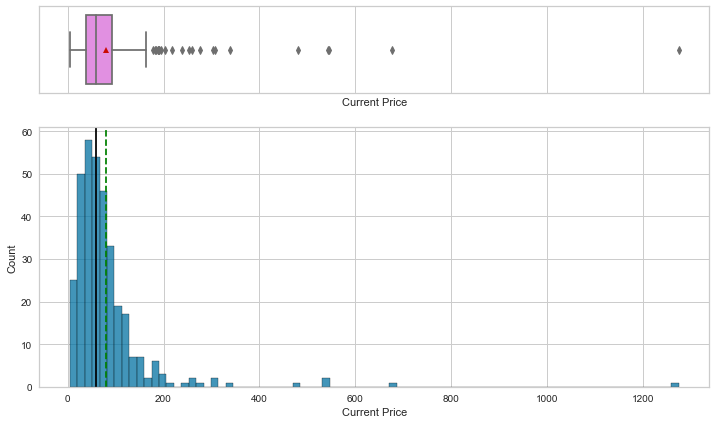

In [162]:
histogram_boxplot(data,'Current Price')

Comment: Right skewed distrbution with many outliers.

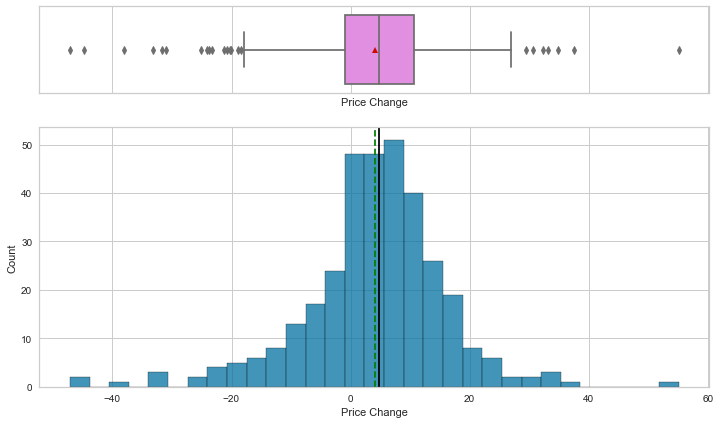

In [163]:
histogram_boxplot(data,'Price Change')

Comment: Distribution for prie change is very slightly sewed tothe left,and has many outliers.

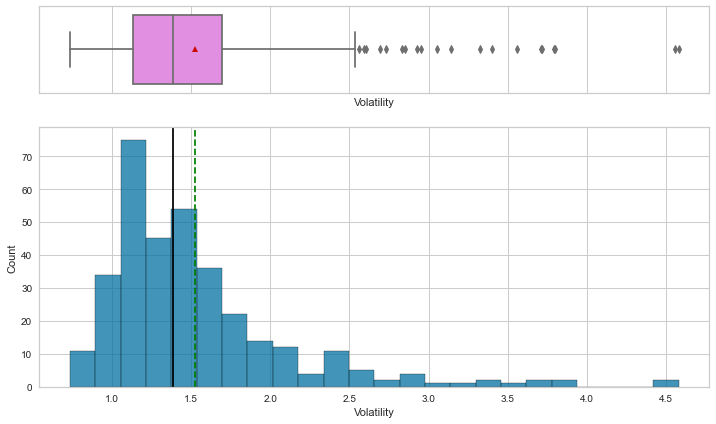

In [164]:
histogram_boxplot(data,'Volatility')

Comment: Right Skewed distribution with quitea few outliers.

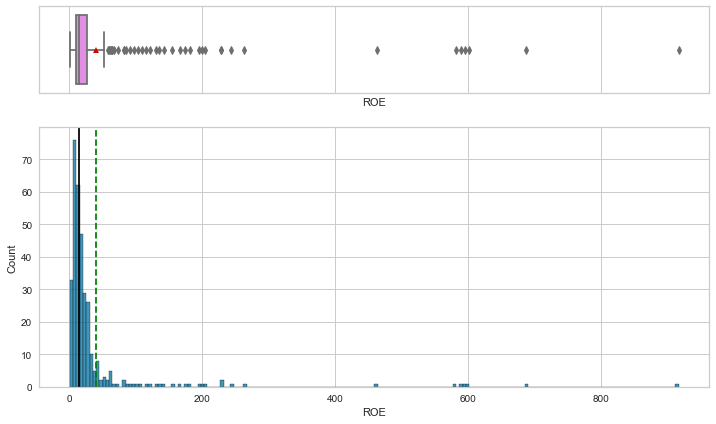

In [22]:
histogram_boxplot(data,'ROE')

Comment: Right skewed distributionwith many distanct outliers. 

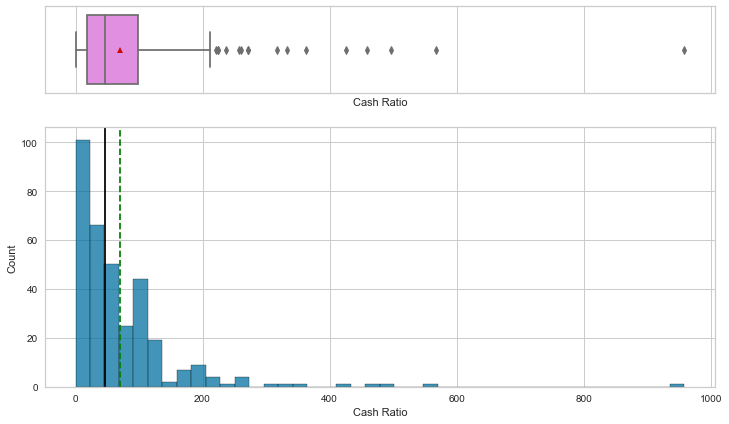

In [23]:
histogram_boxplot(data,'Cash Ratio')

Comment Right Skewed distribution with some outliers. The distribution looks more lke half of the normal distribution. 

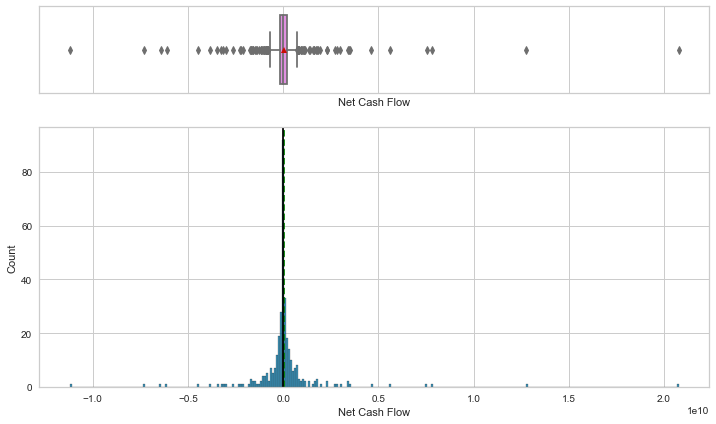

In [24]:
histogram_boxplot(data,'Net Cash Flow')

Comment: distribution has many outliers. 

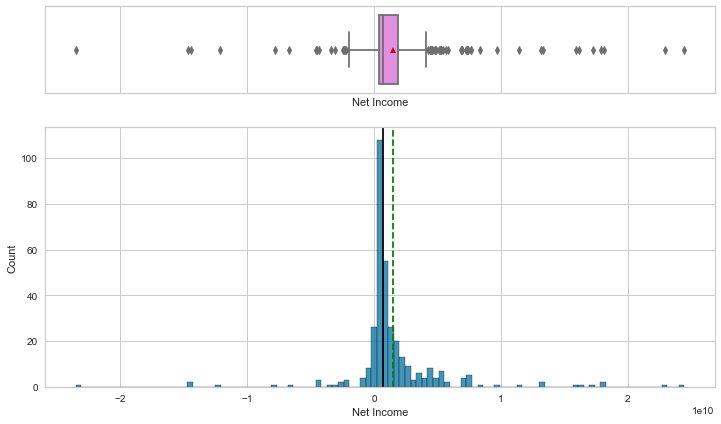

In [25]:
histogram_boxplot(data,'Net Income')

Comment; right skewed distribution with many outliers.

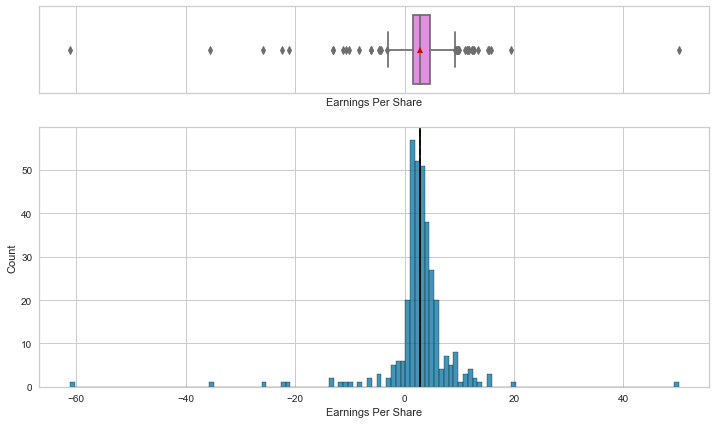

In [26]:
histogram_boxplot(data,'Earnings Per Share')

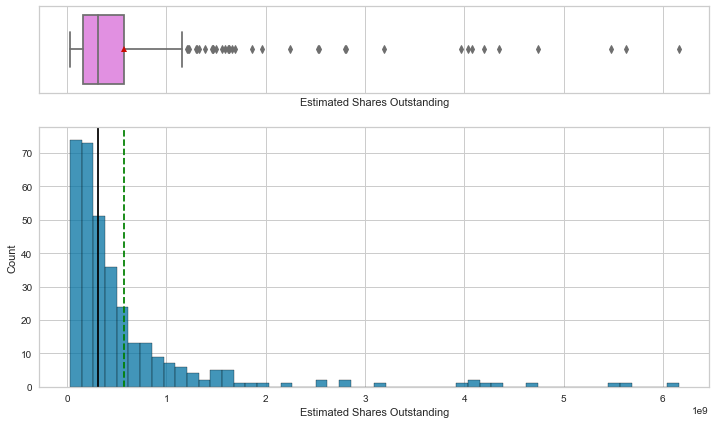

In [27]:
histogram_boxplot(data,'Estimated Shares Outstanding')

Riht skewed distribtuion with many outliers. 

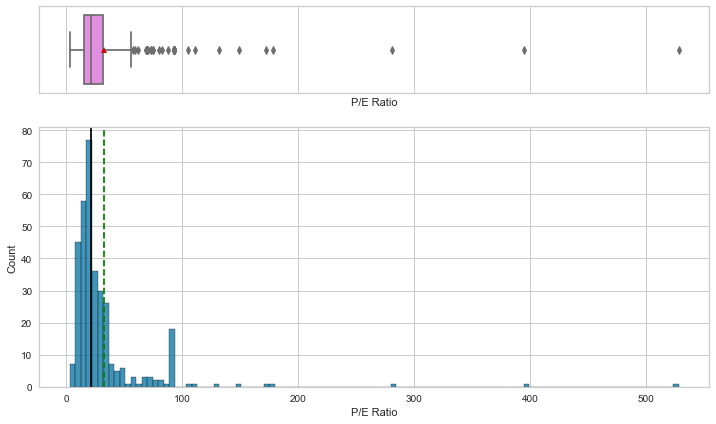

In [28]:
histogram_boxplot(data,'P/E Ratio')

Right skewed distribution. SOmeoutlier. 3 very distant outliers.

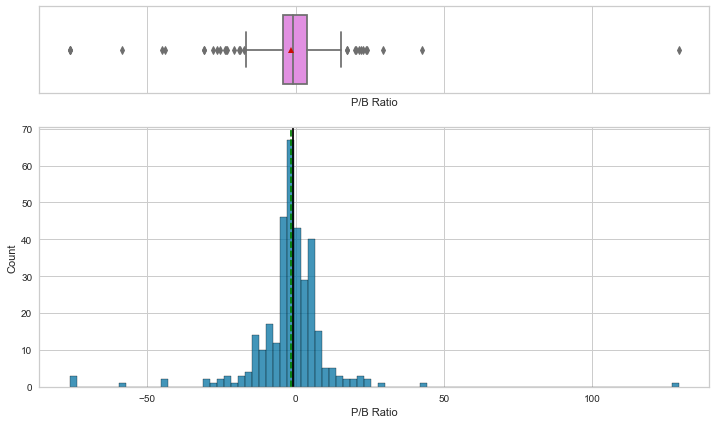

In [29]:
histogram_boxplot(data,'P/B Ratio')

Conclusions:
1) some features have skewed dirtibutions

2) Some feaures have distribution that resembles normal distribution

3) Many otliers for majoriy of the variables

## Bivariate analysis

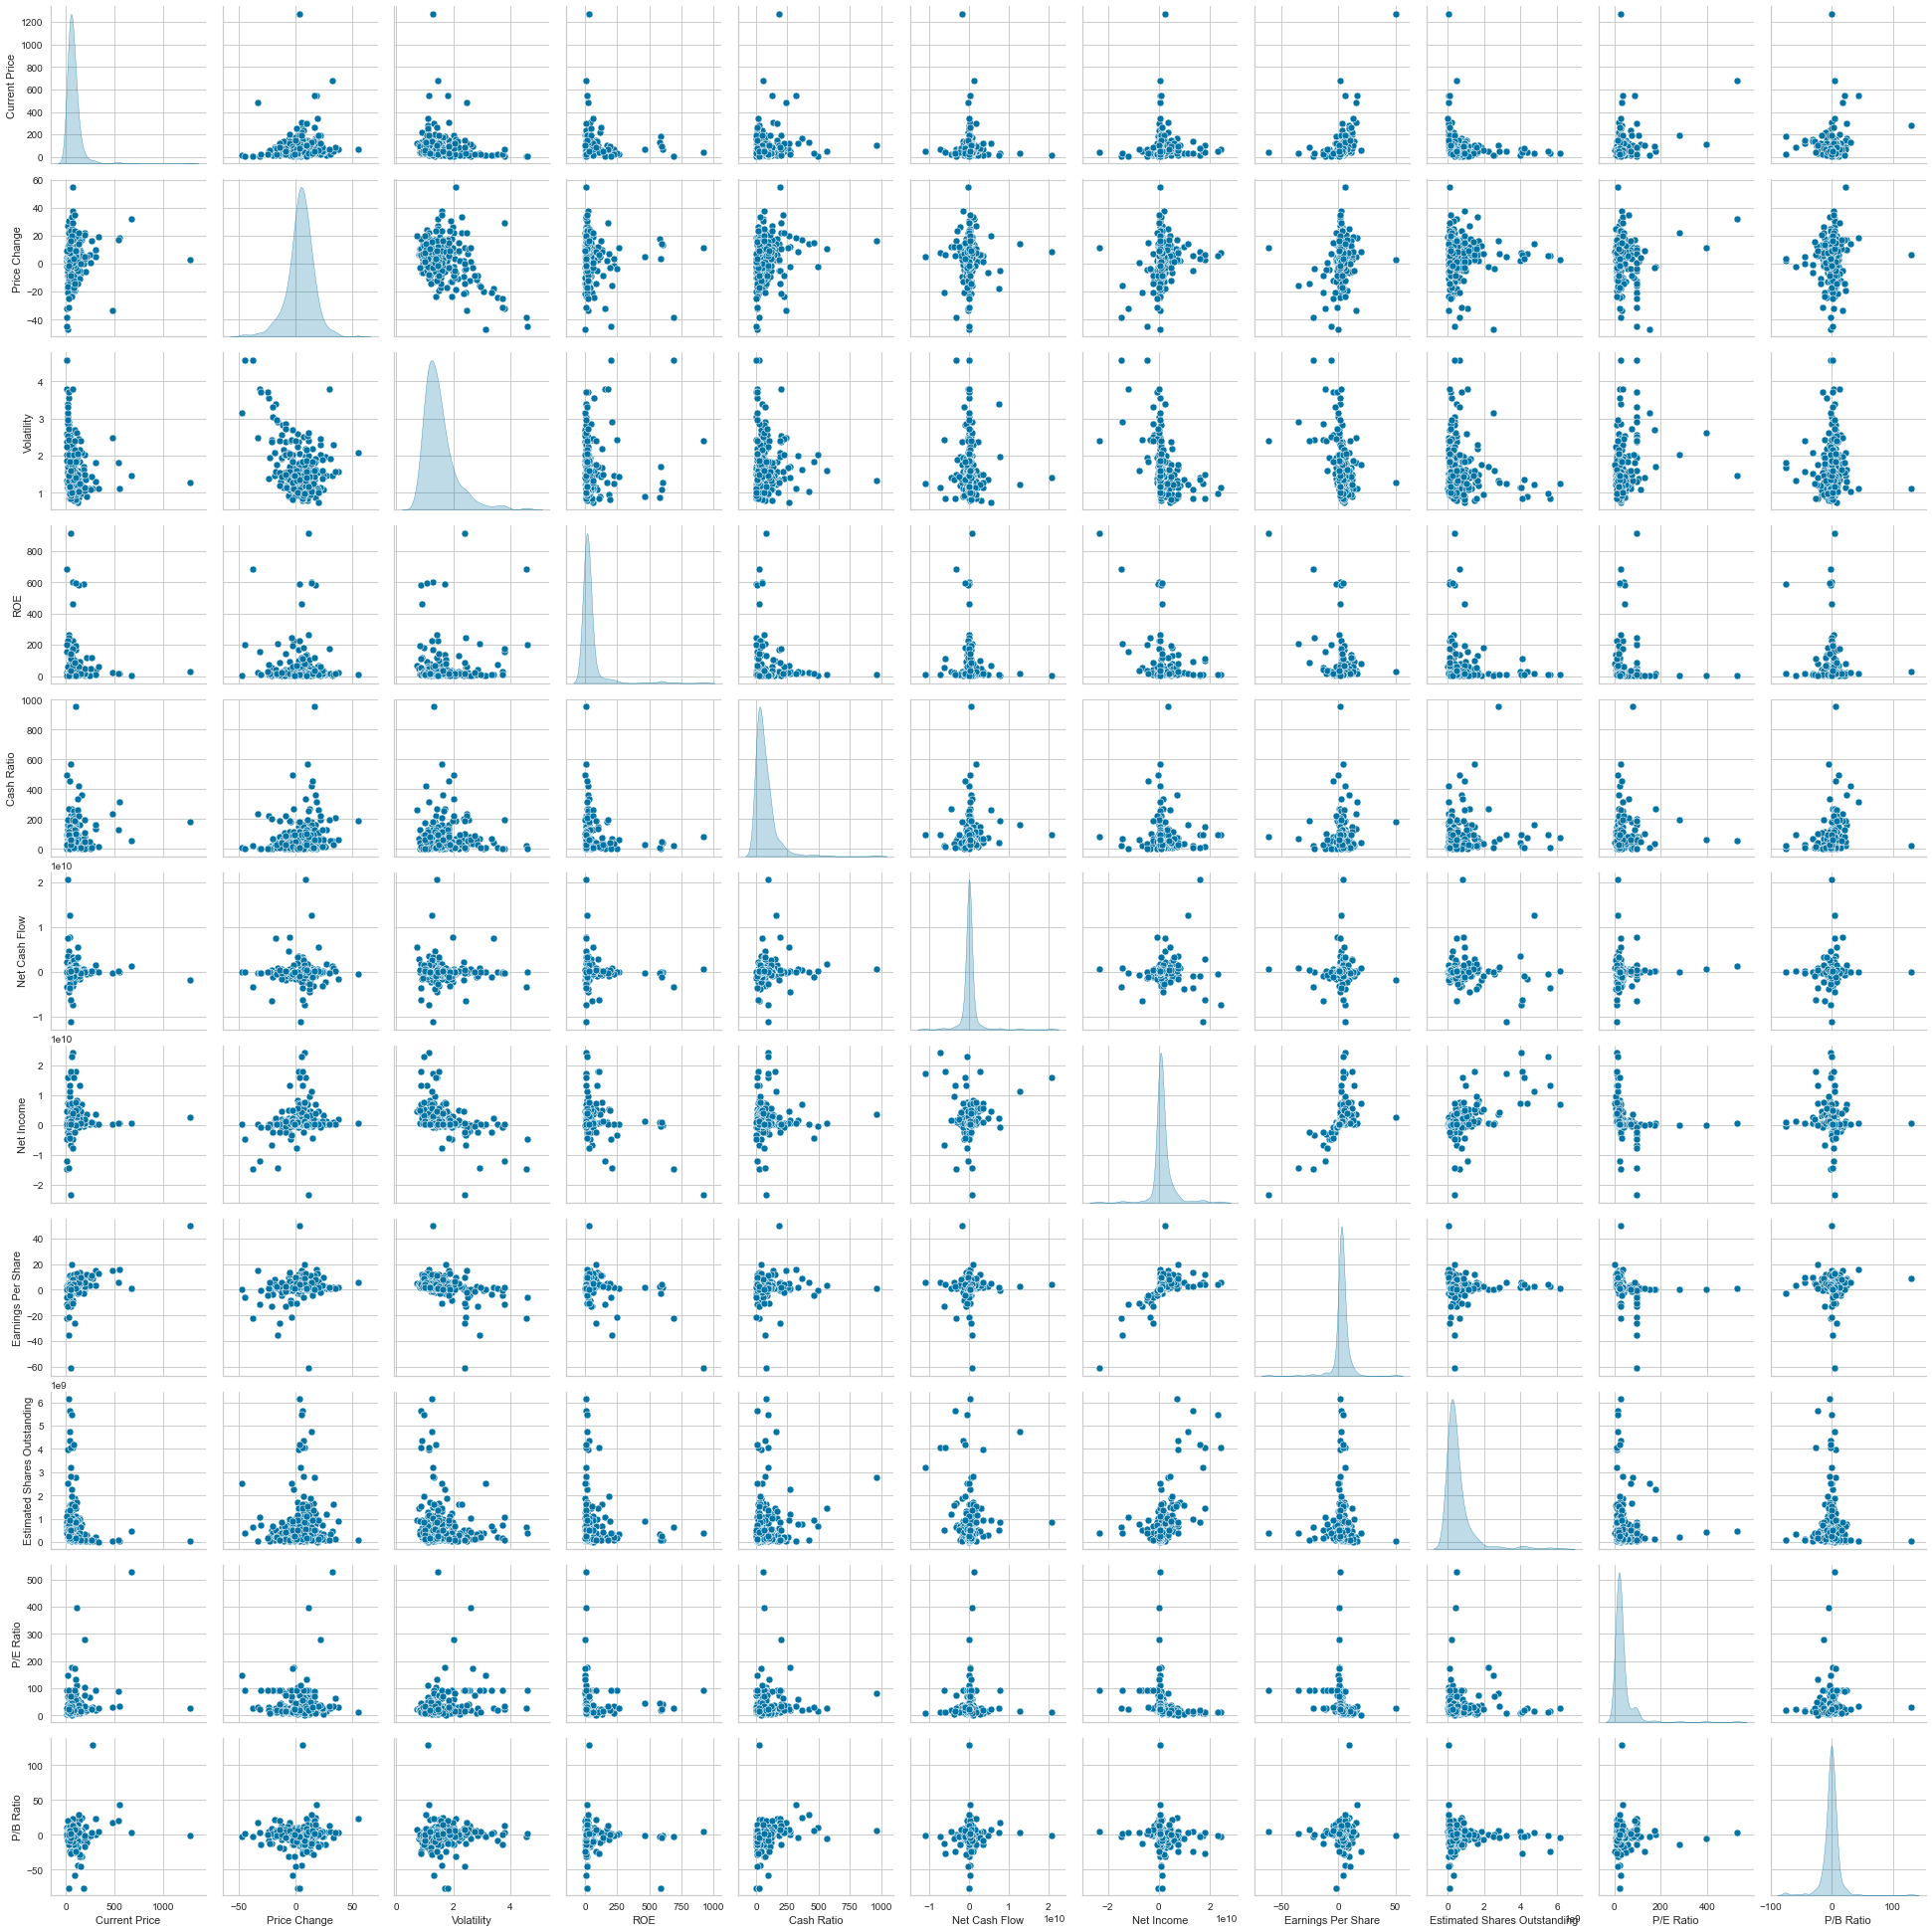

In [30]:
sns.pairplot(data,diag_kind='kde')

### Conclusions based on pairplot: 
    
1. Volatility, Estimated Shares Outstanding and P/E Ratio kde seems to show some clusters. For the other features 
one cannot clearly see clusters onthe plot, there seem to be one bog cluster and maybe some small ones.

2. Most of the featres do not seem to be linearly dependent. Except NetIncome vs Estimated Shares Outstanding - where one can see some linear dependence. Maybe Price Change vs Volatility also have inversely proportional linear dependence. 

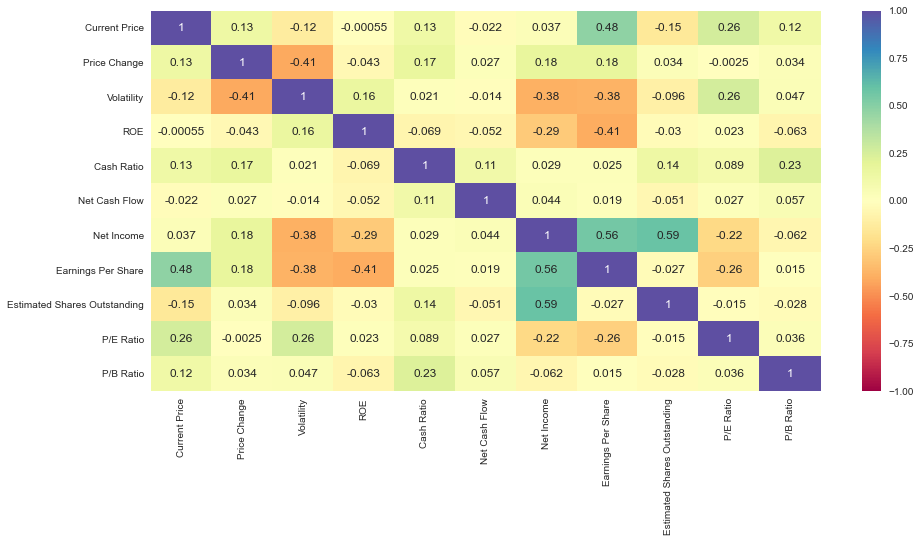

In [31]:
plt.figure(figsize=(15,7))
sns.heatmap(data.corr(),annot=True,vmin=-1,vmax=1,cmap="Spectral")
plt.show()

### Conclusion

Correlation matrix confirms the  previous conclusions - 

1)Most of the featres do not seem to be linearly dependent. 

2) Except some weaker correlation between Net Income vs Estimated Shares Outstanding AND NetIncome and Earnings per Share, positive correlation. 

3) Also Price Change vs Volatility are inversely proportional correlated as could be seen on pairplot. 

Plotting pairplot (using hue="GICS Sector") to see if different business sectors cluster together - naturally.
(Features like ROE depend on the sector).

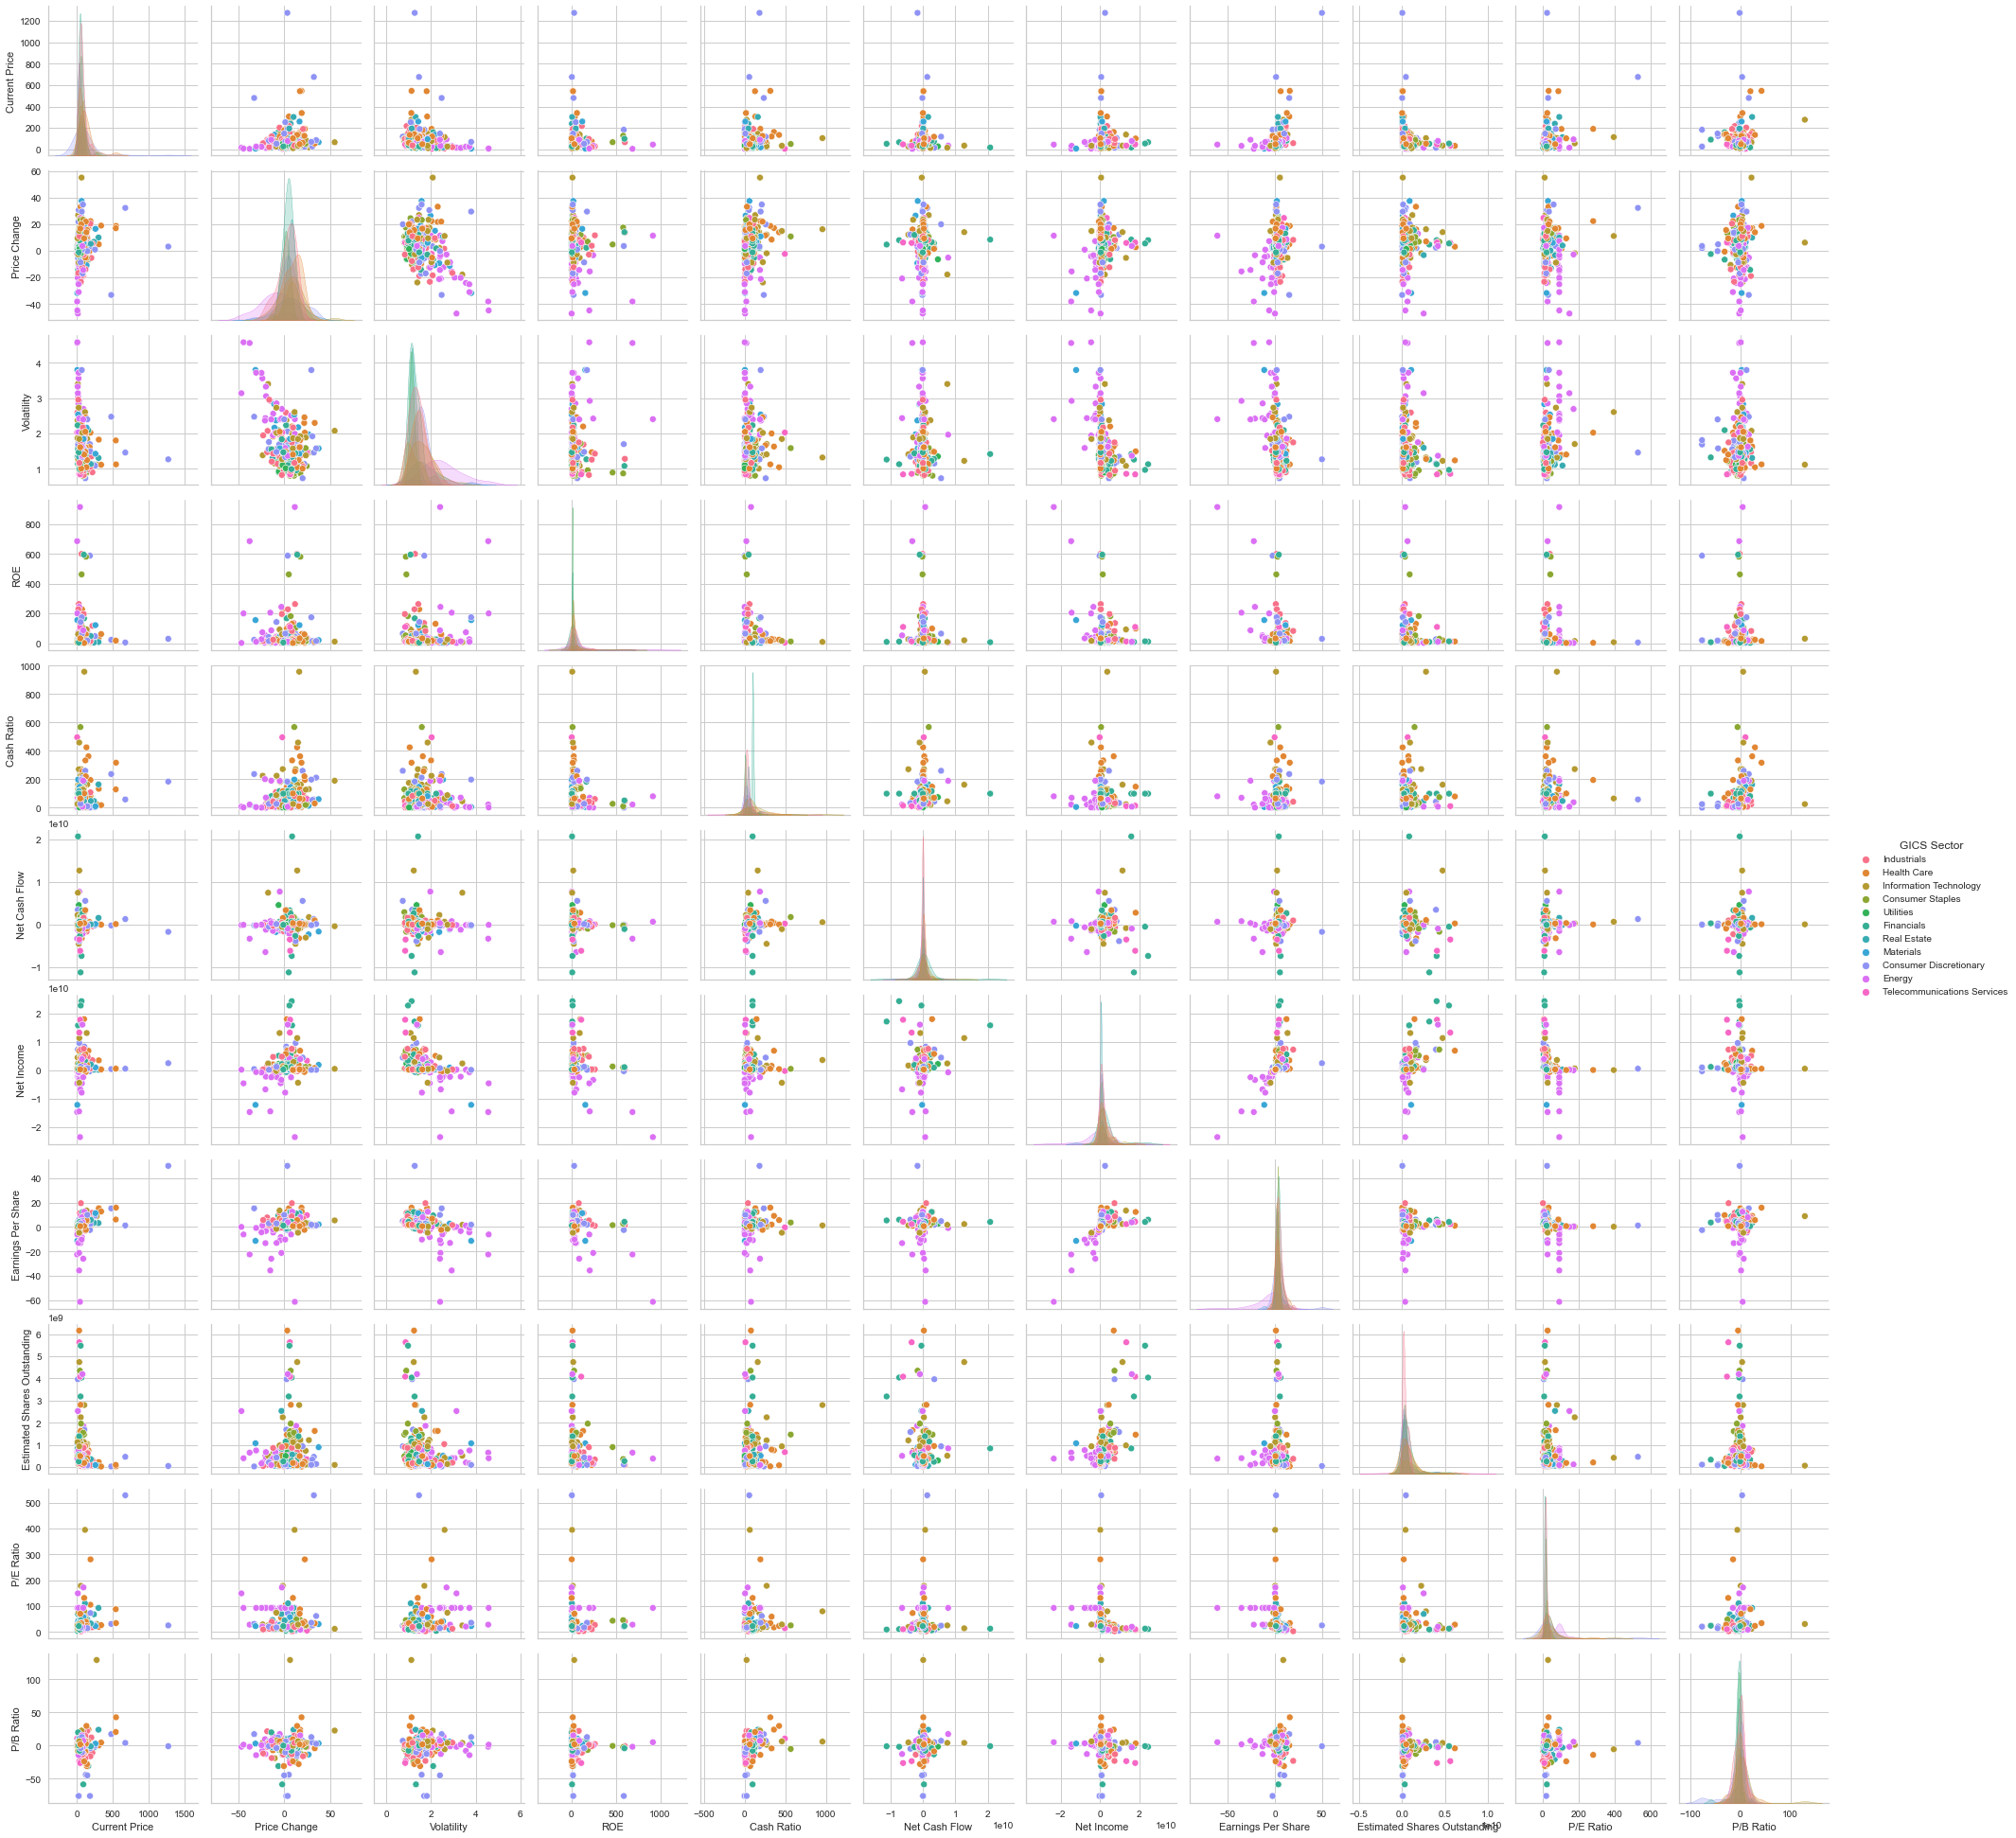

In [32]:
sns.pairplot(data,diag_kind='kde',hue='GICS Sector')

The price distrbutions does not differ between sectors - a lot  ... 
Health Care Real Estate and Consumer Discretionary have the most outliers.

## Conclusions:
    
A. Pairplot for all the data 

1. One cannot see clearly linear dependence between features

2. One cannot see any natural clustersin the data so one can expect that 
the division and separation into meaningful clusters will be more difficult
    
B. Correlation matrix confirms the  previous conclusions - 

1) Most of the featres do not seem to be linearly dependent. 

2) Except some weaker correlation between Net Income vs Estimated Shares Outstanding AND Net Income and Earnings per Share, positive correlation. 

3) Also Price Change vs Volatility are inversely proportional correlated as could be seen on pairplot. 

C. Pairplot with marked different industry Sectors data

1. The price distrbutions does not differ between sectors - a lot ... 

2. Health Care Real Estate and Consumer Discretionary have the most outliers.




## Questions and Answers

**Questions**:

1. What does the distribution of stock prices look like?
2. The stocks of which economic sector have seen the maximum price increase on average?
3. How are the different variables correlated with each other?
4. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?
5. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

## Question 1. What does the distribution of stock prices look like?

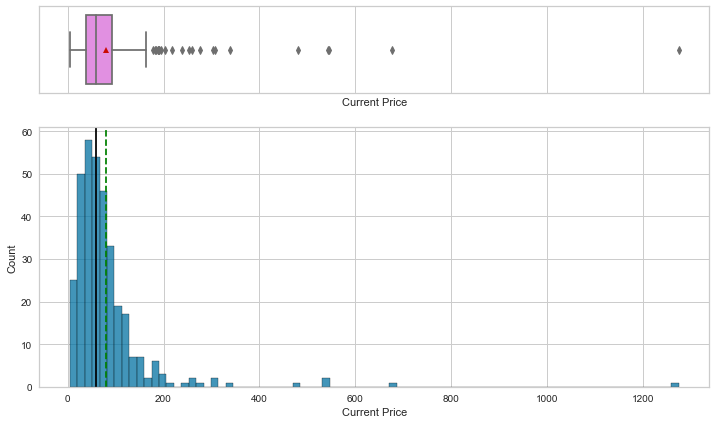

In [34]:
histogram_boxplot(data,'Current Price')

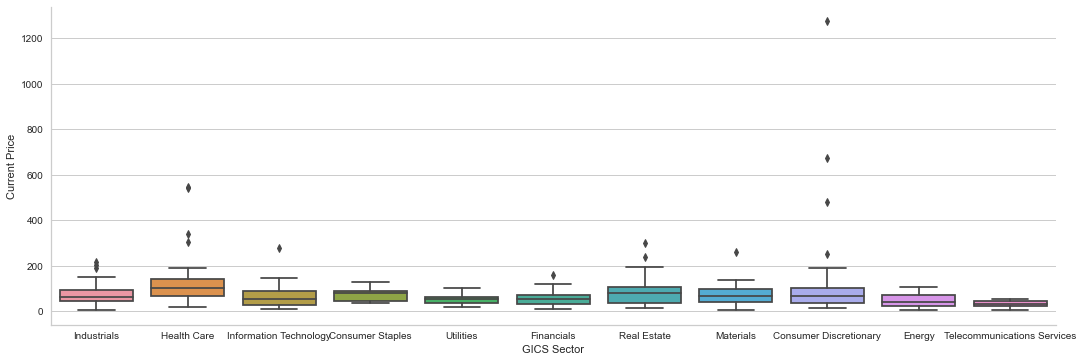

In [33]:
sns.catplot(x="GICS Sector", y="Current Price", data=data, kind="box", height=5, aspect=3)

### Answer: The distribution of the stock prices is right skewed with outliers.  The highest average stock price is for Health Care sector (132 dollars), 2nd highest price is Consumer Discretionary (128 dollars), while the lowest  averagestock price is for Telecommunication Services (33 dollars).

## NOTE:questions about sectors I will answer using the groupby calculations below:

In [294]:
datagroupsector = data.groupby(['GICS Sector'])

In [295]:
datagroupsector.mean()

Current Price  Price Change  Volatility  \
GICS Sector                                                            
Consumer Discretionary          128.095404      5.846093    1.595478   
Consumer Staples                 71.972807      8.684750    1.152675   
Energy                           46.042334    -10.228289    2.568777   
Financials                       58.659183      3.865406    1.267255   
Health Care                     132.048250      9.585652    1.541023   
Industrials                      74.411807      2.833127    1.416989   
Information Technology           63.548485      7.217476    1.659801   
Materials                        76.551500      5.589738    1.816726   
Real Estate                      90.976925      6.205548    1.206053   
Telecommunications Services      32.964000      6.956980    1.341612   
Utilities                        52.968542      0.803657    1.118018   

                                   ROE  Cash Ratio  Net Cash Flow  \
GICS Sector                                                         
Consumer Discretionary       44.900000   49.575000   8.421318e+07   
Consumer Staples             89.421053   70.947368   2.586272e+08   
Energy                       93.200000   51.133333  -3.083182e+08   
Financials                   26.285714   98.591837   2.543563e+08   
Health Care                  27.775000  103.775000   2.626878e+08   
Industrials                  50.150943   36.188679  -1.601032e+08   
Information Technology       21.787879  149.818182   4.830991e+08   
Materials                    33.000000   41.700000  -2.912368e+08   
Real Estate                  12.444444   50.111111   3.546704e+06   
Telecommunications Services  32.600000  117.000000  -1.816800e+09   
Utilities                     9.875000   13.625000   1.764623e+08   

                               Net Income  Earnings Per Share  \
GICS Sector                                                     
Consumer Discretionary       1.373450e+09            4.525750   
Consumer Staples             2.518833e+09            3.224211   
Energy                      -2.087527e+09           -6.908333   
Financials                   3.202678e+09            4.220408   
Health Care                  2.018515e+09            4.541250   
Industrials                  1.722373e+09            4.456792   
Information Technology       1.701587e+09            2.266061   
Materials                    2.785165e+08            3.129000   
Real Estate                  5.677757e+08            2.340000   
Telecommunications Services  7.067800e+09            3.550000   
Utilities                    1.107146e+09            2.753125   

                             Estimated Shares Outstanding  P/E Ratio  \
GICS Sector                                                            
Consumer Discretionary                       3.996513e+08  35.211613   
Consumer Staples                             9.136852e+08  25.521195   
Energy                                       6.635288e+08  72.897709   
Financials                                   6.838773e+08  16.023151   
Health Care                                  6.845955e+08  41.135272   
Industrials                                  3.547169e+08  18.259380   
Information Technology                       8.282789e+08  43.782546   
Materials                                    3.085246e+08  24.585352   
Real Estate                                  3.444540e+08  43.065585   
Telecommunications Services                  2.259575e+09  12.222578   
Utilities                                    3.809193e+08  18.719412   

                             P/B Ratio  
GICS Sector                             
Consumer Discretionary       -8.253543  
Consumer Staples             -4.554003  
Energy                        2.539738  
Financials                   -4.270505  
Health Care                   0.068869  
Industrials                  -0.979266  
Information Technology        6.377128  
Materials                     0.723103  
R

Comments: Highest average price is for Consumer Discretionary and Health care.
The worst price change is for energy (-10%), and best for Health Care.
Highest average volatility is for Energy sector.
Largest Cash Ratio is again for Health Care and IT and Telecom. Service.



## Question 2. The stocks of which economic sector have seen the maximum price increase on average?

In [296]:
datagroupsector.median()

Current Price  Price Change  Volatility   ROE  \
GICS Sector                                                                  
Consumer Discretionary           67.200001      3.543658    1.558442  20.0   
Consumer Staples                 78.949997      6.976738    1.078455  26.0   
Energy                           39.255001     -9.244788    2.413469  20.5   
Financials                       54.360001      3.910301    1.189236  10.0   
Health Care                     101.889999     10.324402    1.492912  16.5   
Industrials                      61.310001      3.952561    1.348597  23.0   
Information Technology           52.630001      7.496965    1.578483  16.0   
Materials                        67.055000      4.906245    1.578999  22.0   
Real Estate                      80.690002      7.578608    1.169328  10.0   
Telecommunications Services      34.410000      5.942118    1.457013  11.0   
Utilities                        52.250000      1.281624    1.112450   9.5   

                             Cash Ratio  Net Cash Flow    Net Income  \
GICS Sector                                                            
Consumer Discretionary             25.0    -14092500.0  6.136510e+08   
Consumer Staples                   33.0     13065000.0  1.013000e+09   
Energy                             38.5    -66575000.0 -7.413425e+08   
Financials                         99.0     10000000.0  1.385000e+09   
Health Care                        70.0    123650000.0  6.947640e+08   
Industrials                        31.0    -42800000.0  6.960670e+08   
Information Technology            126.0     50823000.0  7.635000e+08   
Materials                          25.0     -4950000.0  5.769500e+08   
Real Estate                        47.0      2212000.0  4.875620e+08   
Telecommunications Services        14.0     -2000000.0  3.433000e+09   
Utilities                           8.5      9616000.0  8.832425e+08   

                             Earnings Per Share  Estimated Shares Outstanding  \
GICS Sector                                                                     
Consumer Discretionary                   3.0300                  2.135983e+08   
Consumer Staples                         3.2800                  4.913916e+08   
Energy                                  -2.6250                  4.224191e+08   
Financials                               4.0300                  4.153086e+08   
Health Care                              3.0700                  2.357307e+08   
Industrials                              3.6100                  2.401866e+08   
Information Technology                   1.8000                  5.139877e+08   
Materials                                2.9900                  2.476503e+08   
Real Estate                              2.0100                  2.603358e+08   
Telecommunications Services              2.3700                  6.758621e+08   
Utilities                                2.7275                  3.370058e+08   

                             P/E Ratio  P/B Ratio  
GICS Sector                                        
Consumer Discretionary       20.819876  -0.857290  
Consumer Staples             24.070121  -2.256747  
Energy                       93.089287   1.600930  
Financials                   14.276451  -1.883912  
Health Care                  27.967442  -0.522637  
Industrials                  17.334711   0.902439  
Information Technology       25.309524   3.954975  
Materials                    22.811951   2.880396  
Real Estate                  33.685393  -3.089477  
Telecommunications Services  14.518987 -13.383212  
Utilities                    18.216489  -2.924880

## Answer: On average maximum price increase on average was for Heath Care sector (10.3 %).

## Question 3 How are the different variables correlated with each other?

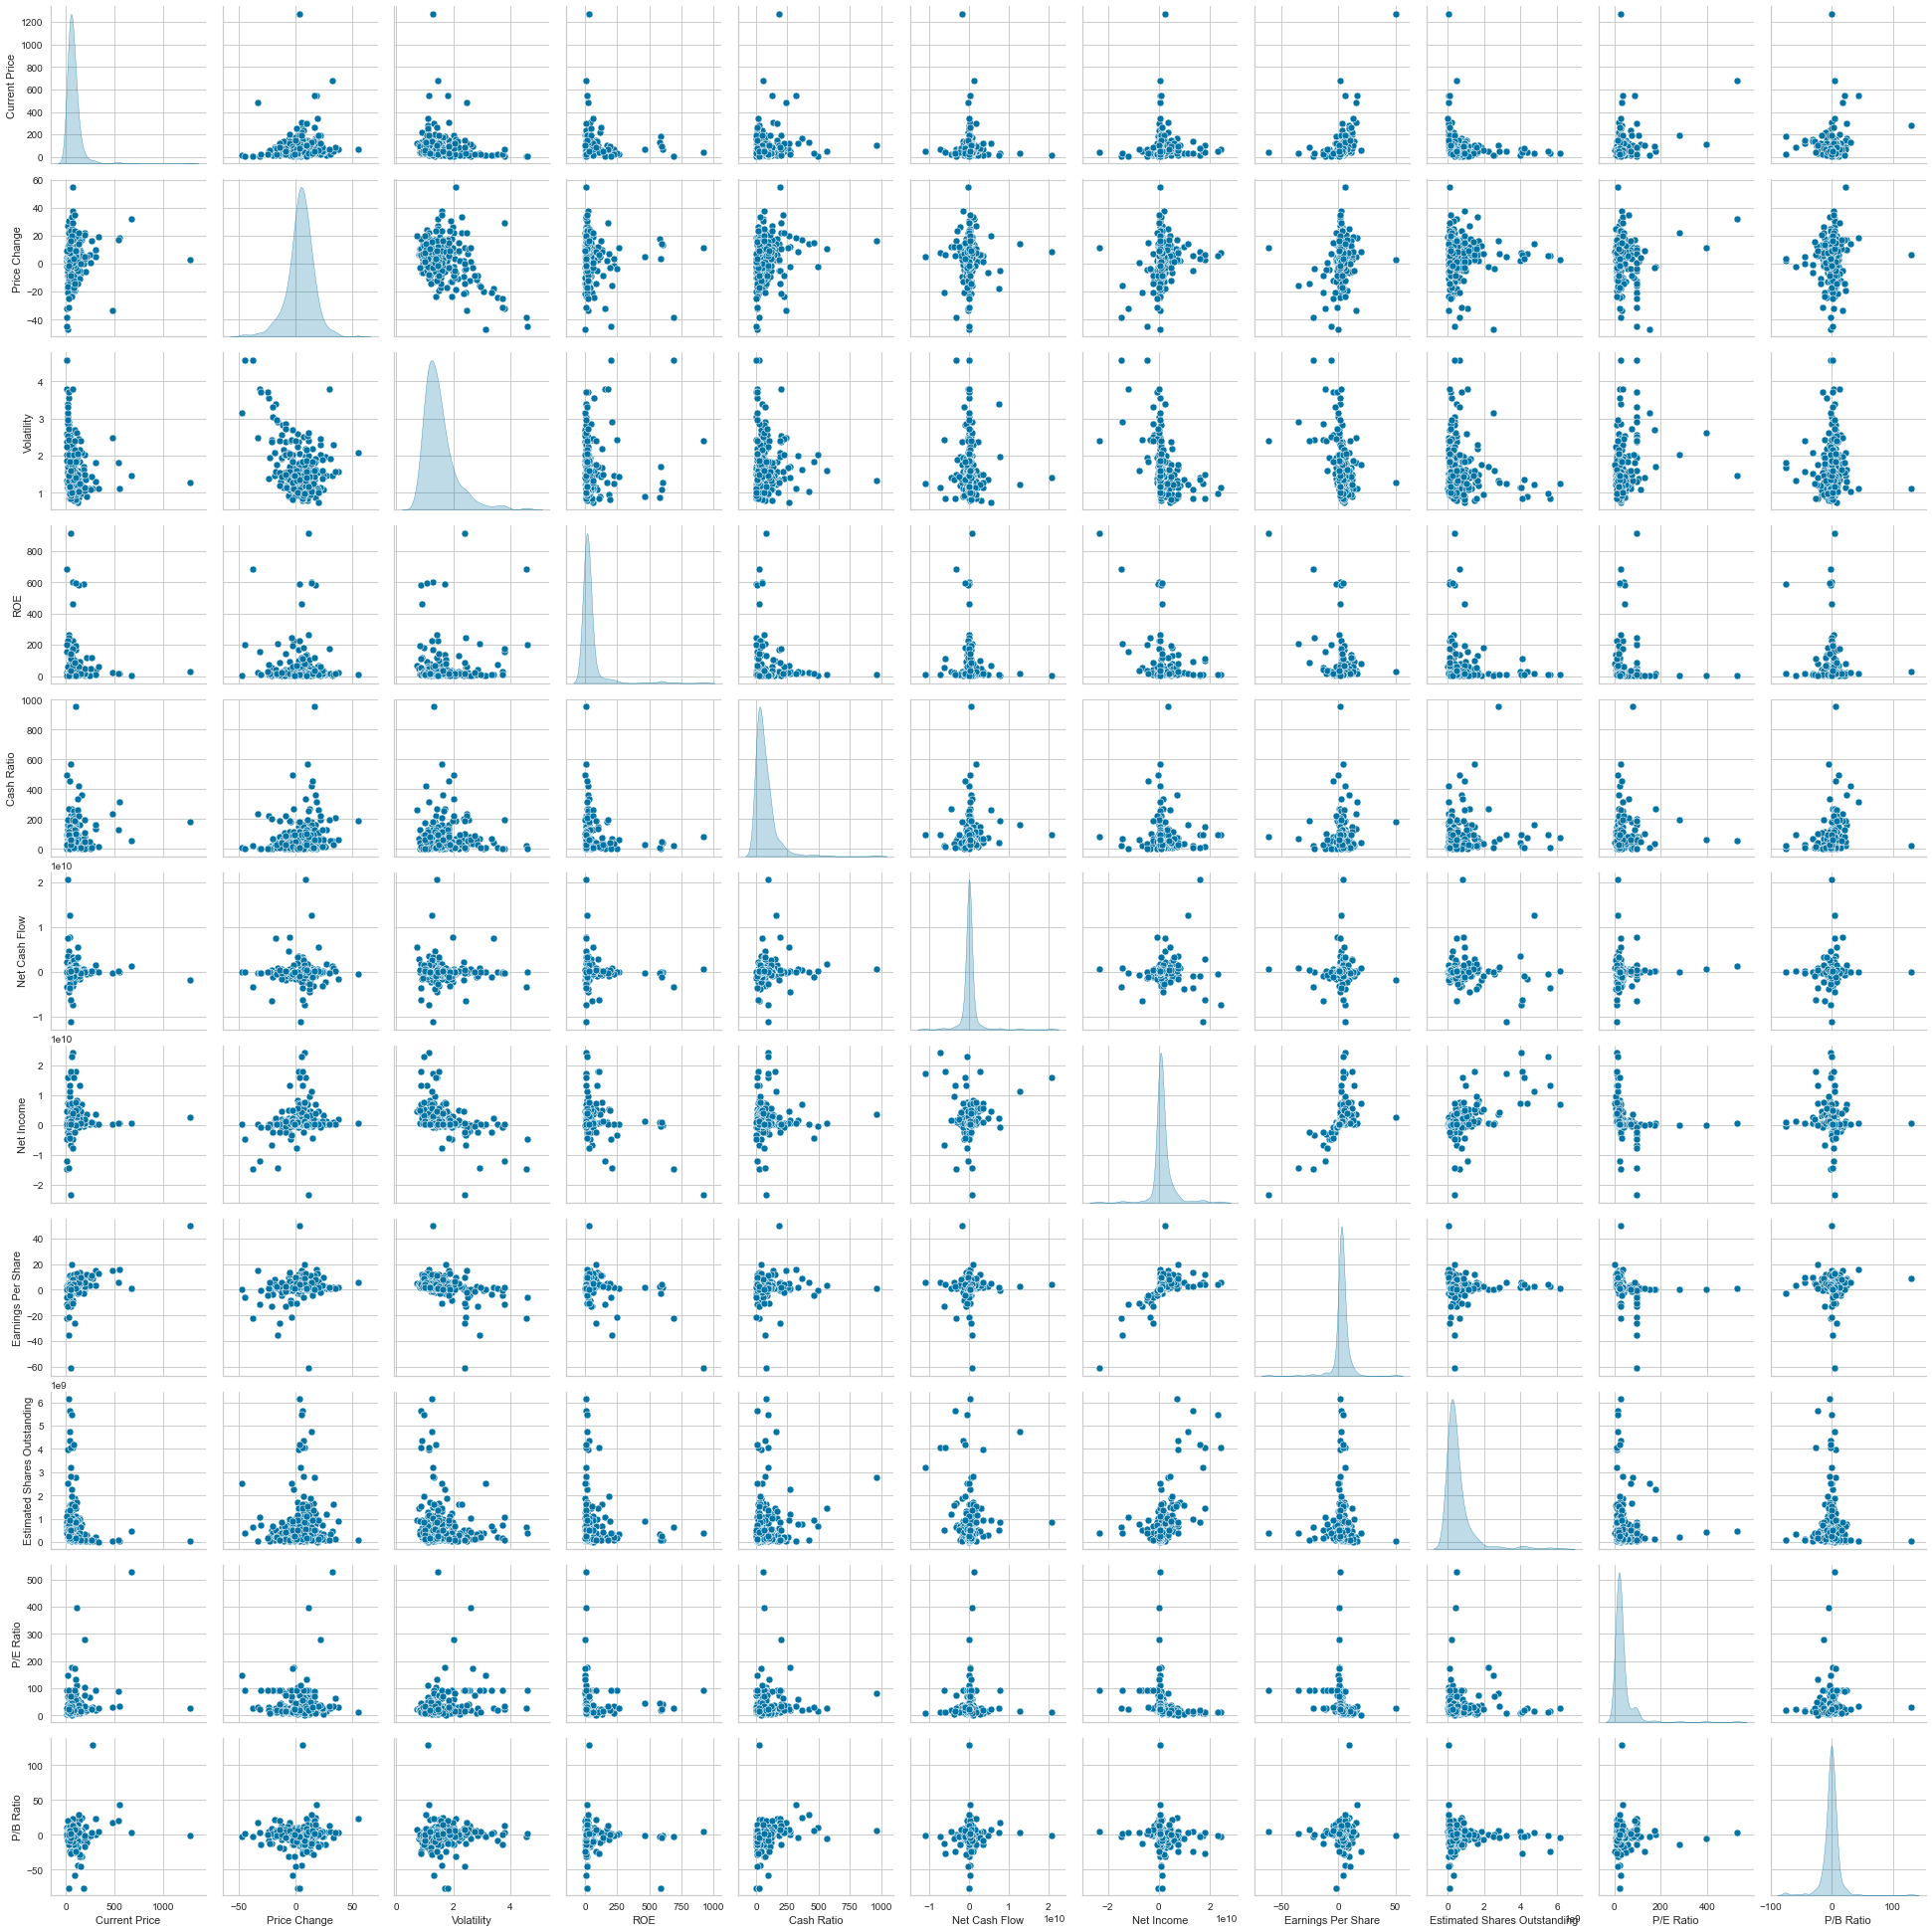

In [38]:
sns.pairplot(data,diag_kind='kde')

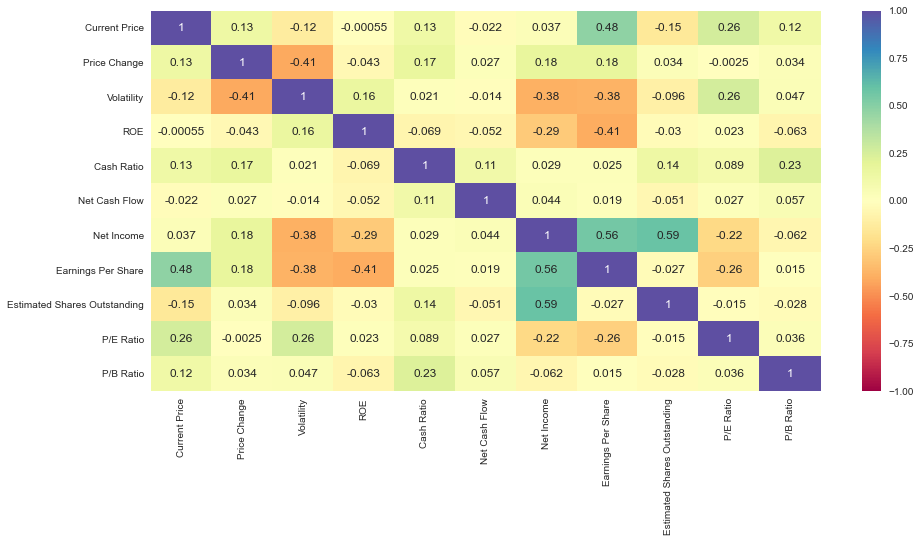

In [39]:
plt.figure(figsize=(15,7))
sns.heatmap(data.corr(),annot=True,vmin=-1,vmax=1,cmap="Spectral")
plt.show()

## Answer:

## A. Conclusions about correlation based on pairplot: *

1)    Volatility, Estimated Shares Outstanding and P/E Ratio kde seems to show some clusters. For the other features one cannot clearly see clusters onthe plot, there seem to be one bog cluster and maybe some small ones.

2)    Most of the featres do not seem to be linearly dependent. Except NetIncome vs Estimated Shares Outstanding - where one can see some linear dependence. Maybe Price Change vs Volatility also have inversely proportional linear dependence.



## B. Conclusion based on correlation matrix 

1)weak correlation between Net Income vs Estimated Shares Outstanding,positive correlation 
2) weak correlation between NetIncome and Earnings per Share, positive correlation. 
3)  Price Change vs Volatility are inversely proportional correlated

## Question 4: Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?

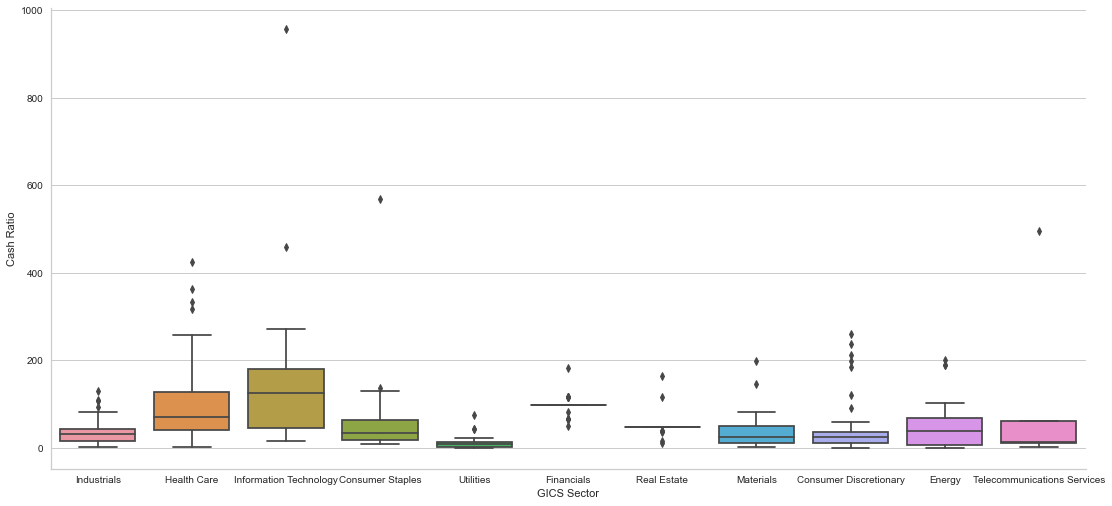

In [292]:
sns.catplot(x="GICS Sector", y="Cash Ratio", data=data, kind="box", height=7, aspect=2.2)

In [297]:
datagroupsector["Cash Ratio"].mean()

GICS Sector
Consumer Discretionary          49.575000
Consumer Staples                70.947368
Energy                          51.133333
Financials                      98.591837
Health Care                    103.775000
Industrials                     36.188679
Information Technology         149.818182
Materials                       41.700000
Real Estate                     50.111111
Telecommunications Services    117.000000
Utilities                       13.625000
Name: Cash Ratio, dtype: float64

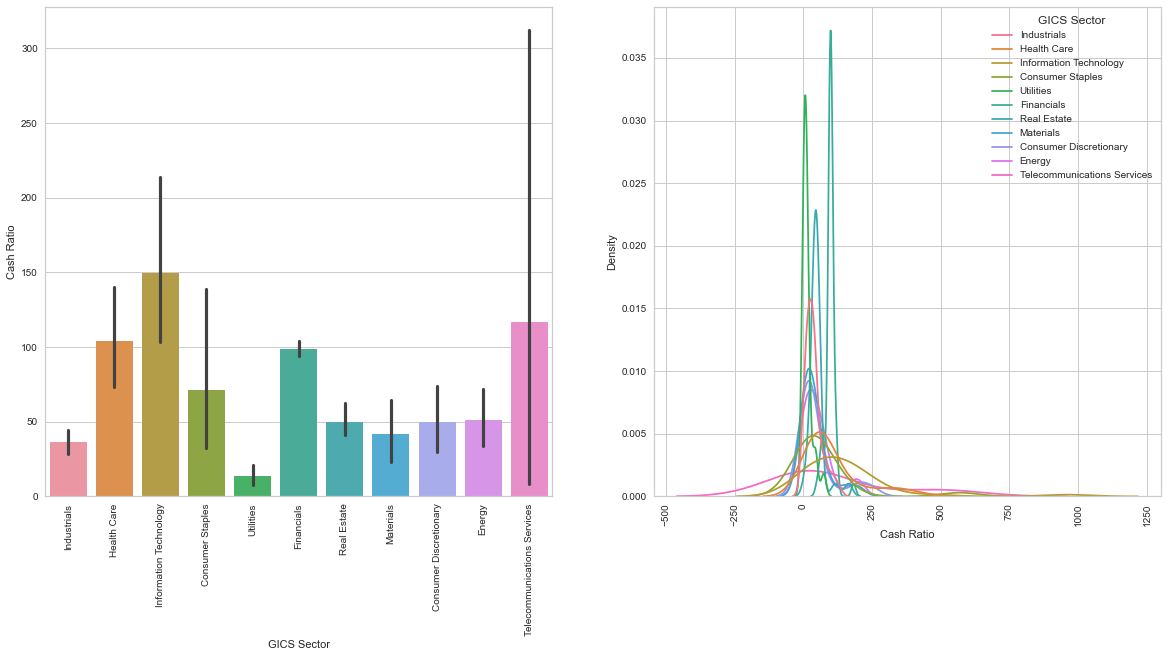

In [41]:
plt.figure(figsize=(20, 9))

plt.subplot(1, 2, 1)
sns.barplot(data=data, x="GICS Sector", y="Cash Ratio")
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.kdeplot(data=data, x="Cash Ratio", hue="GICS Sector", common_norm=False)
plt.xticks(rotation=90)

plt.show()


## Answer: The largest average cash ratio is highest for Information Technology (150),Telecommunication Services (117) and Health care (104). The smallest average cash ratio is for Utilities (13).

## Question 5. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

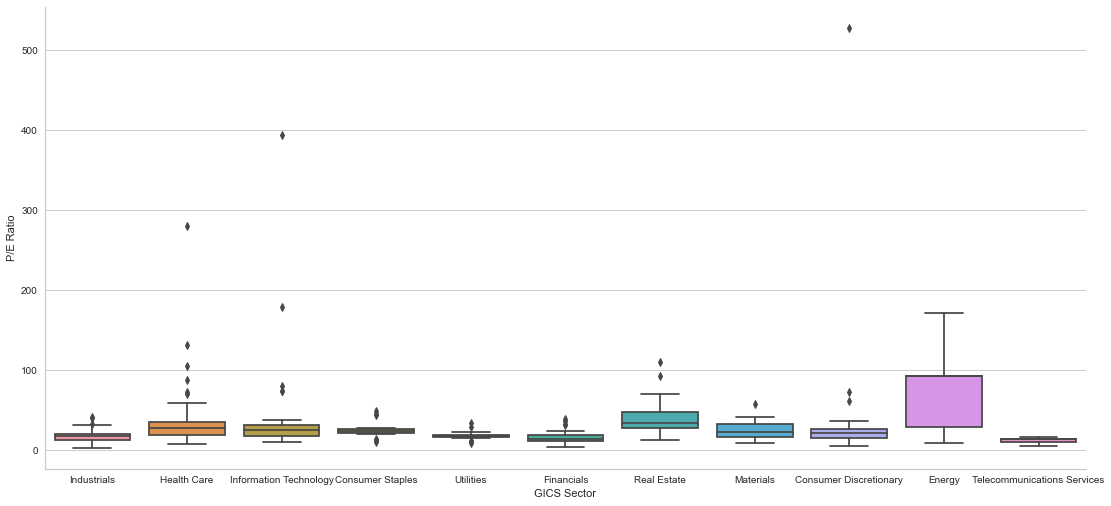

In [42]:
sns.catplot(x="GICS Sector", y="P/E Ratio", data=data, kind="box", height=7, aspect=2.2)

In [298]:
datagroupsector["P/E Ratio"].mean()

GICS Sector
Consumer Discretionary         35.211613
Consumer Staples               25.521195
Energy                         72.897709
Financials                     16.023151
Health Care                    41.135272
Industrials                    18.259380
Information Technology         43.782546
Materials                      24.585352
Real Estate                    43.065585
Telecommunications Services    12.222578
Utilities                      18.719412
Name: P/E Ratio, dtype: float64

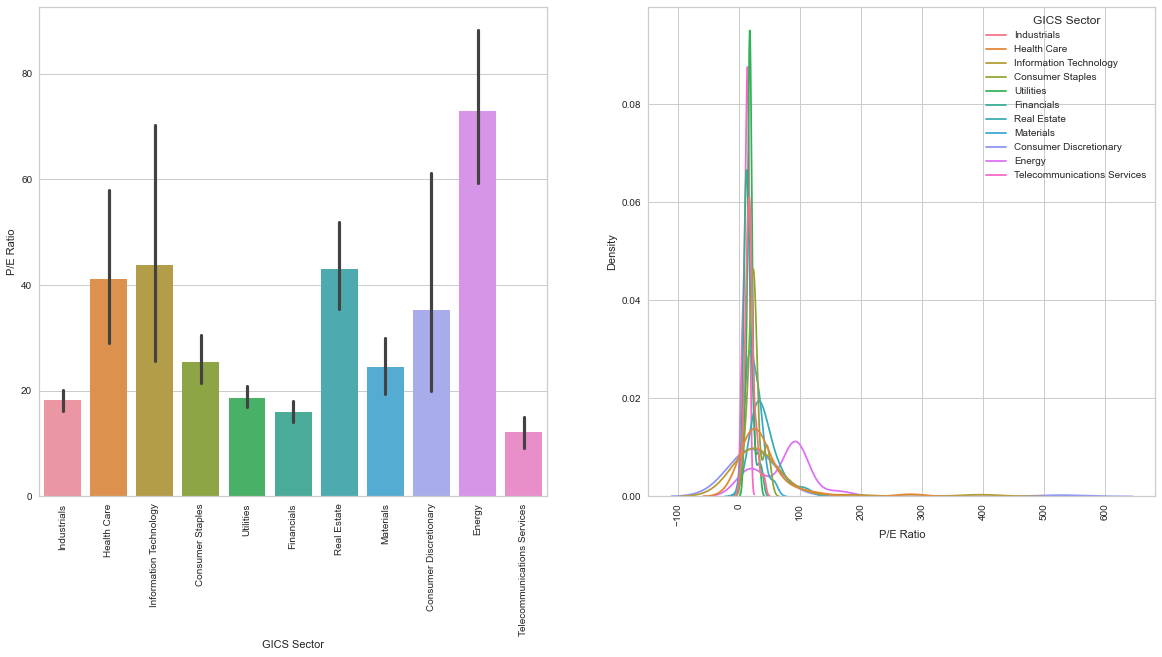

In [43]:
plt.figure(figsize=(20, 9))

plt.subplot(1, 2, 1)
sns.barplot(data=data, x="GICS Sector", y="P/E Ratio")
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.kdeplot(data=data, x="P/E Ratio", hue="GICS Sector", common_norm=False)
plt.xticks(rotation=90)

plt.show()


## Answer. The average values for P/E Ratio fordifferent sectors ranges from 12  to 73. 
Largest average P/E Ratio is for sectors: Energy (73), Inf. Tech. (44) and Real Estate (43).
The smallest average PE Ratio is for Telecom.Services (12). 

The median values for P/E Ratio is the highest for Energy (93) and Real Estate (34). For  rest of the sectors median P/E ratio falls into narrower range of 14-25.

## Prepaing the data for clustering - because the features have very different ranges wened to scale the data. I will use the Standard Scaler.

### Scaling the data using standard scaler 

In [165]:
# selecting numerical columns
num_col = data.select_dtypes(include=np.number).columns.tolist()

In [166]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = data[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [167]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

In [168]:
subset_scaled_df

Current Price  Price Change  Volatility       ROE  Cash Ratio  \
0        -0.393341      0.493950    0.272749  0.989601   -0.210698   
1        -0.220837      0.355439    1.137045  0.937737    0.077269   
2        -0.367195      0.602479   -0.427007 -0.192905   -0.033488   
3         0.133567      0.825696   -0.284802 -0.317379    1.218059   
4        -0.260874     -0.492636    0.296470 -0.265515    2.237018   
..             ...           ...         ...       ...         ...   
335      -0.486181      0.901646    0.540121 -0.255142    4.308162   
336      -0.289510     -1.065766   -0.079703  1.062211   -0.476513   
337       0.221913      0.439539   -0.206067 -0.400362    0.332009   
338      -0.547053     -0.436811   -0.097813 -0.369243    0.320933   
339      -0.336453      1.051046    0.142671 -0.078803   -0.055639   

     Net Cash Flow  Net Income  Earnings Per Share  \
0        -0.339355    1.554415            1.309399   
1        -0.002335    0.927628            0.056755   
2         0.454058    0.744371            0.024831   
3        -0.152497   -0.219816           -0.230563   
4         0.133564   -0.202703           -0.374982   
..             ...         ...                 ...   
335      -0.559673   -1.487784           -1.127481   
336       0.053235   -0.051186            0.029391   
337       0.164889   -0.342467           -0.303532   
338      -0.051022   -0.301171           -0.239684   
339       0.111378   -0.293666           -0.318734   

     Estimated Shares Outstanding  P/E Ratio  P/B Ratio  
0                        0.107863  -0.652487  -0.506653  
1                        1.250274  -0.311769  -0.504205  
2                        1.098021  -0.391502   0.094941  
3                       -0.091622   0.947148   0.424333  
4                        1.978399   3.293307   0.199196  
..                            ...        ...        ...  
335                      0.429111  -0.082116   0.572194  
336                     -0.167741  -0.337154  -0.152012  
337                     -0.460058   2.233634  -1.589390  
338                     -0.377852  -0.222714   0.118680  
339                     -0.092942   0.854902   0.246754  

[340 rows x 11 columns]

## EDA

- It is a good idea to explore the data once again after manipulating it.

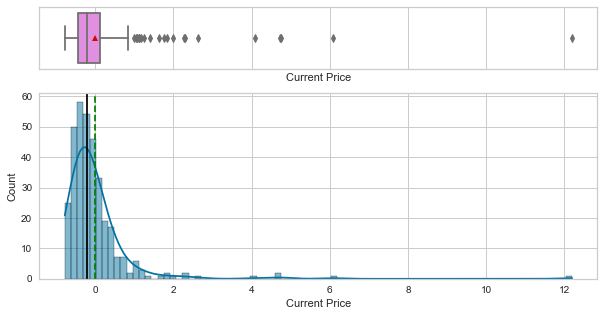

In [50]:
histogram_boxplot(subset_scaled_df, "Current Price", kde=True, figsize=(10, 5))

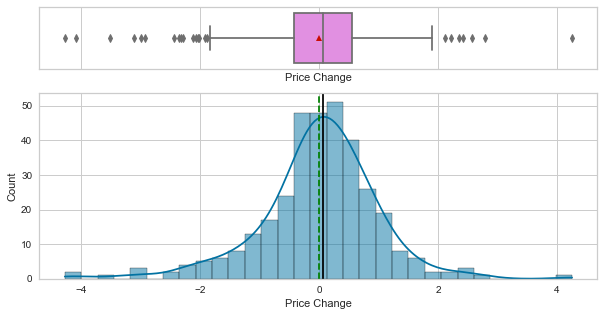

In [51]:
histogram_boxplot(subset_scaled_df, "Price Change", kde=True, figsize=(10, 5))

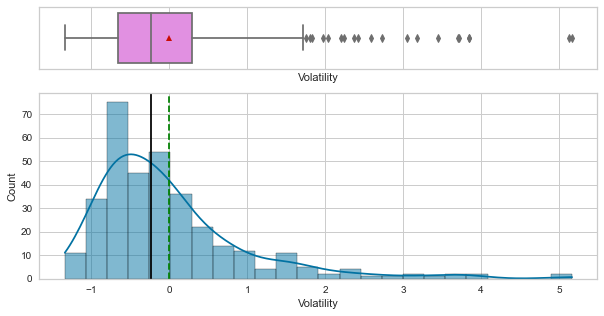

In [52]:
histogram_boxplot(subset_scaled_df, "Volatility", kde=True, figsize=(10, 5))

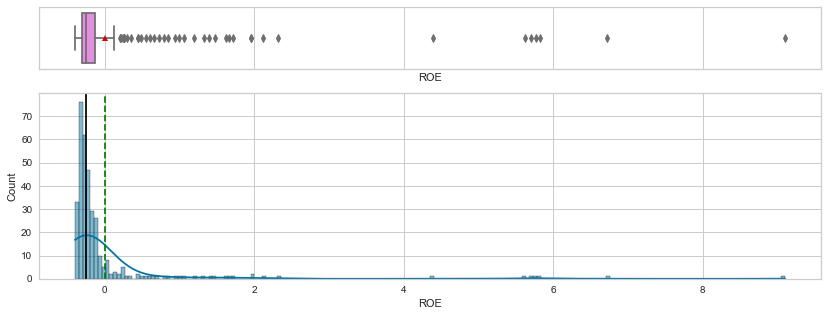

In [55]:
histogram_boxplot(subset_scaled_df, "ROE", kde=True, figsize=(14, 5))

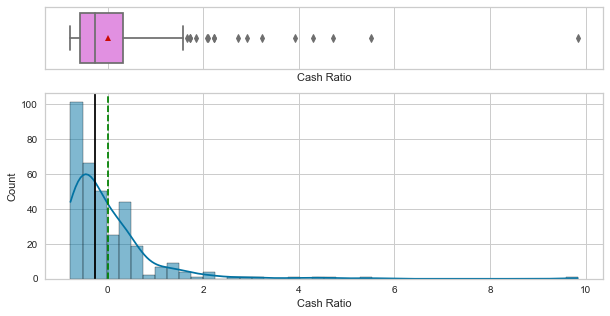

In [56]:
histogram_boxplot(subset_scaled_df, "Cash Ratio", kde=True, figsize=(10, 5))

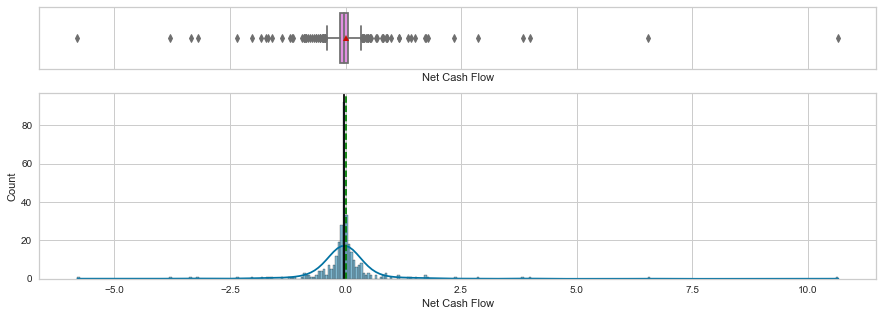

In [59]:
histogram_boxplot(subset_scaled_df, "Net Cash Flow", kde=True, figsize=(15, 5))

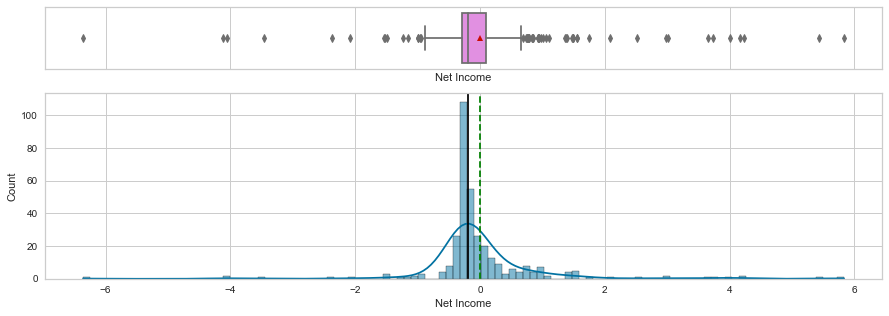

In [60]:
histogram_boxplot(subset_scaled_df, "Net Income", kde=True, figsize=(15, 5))

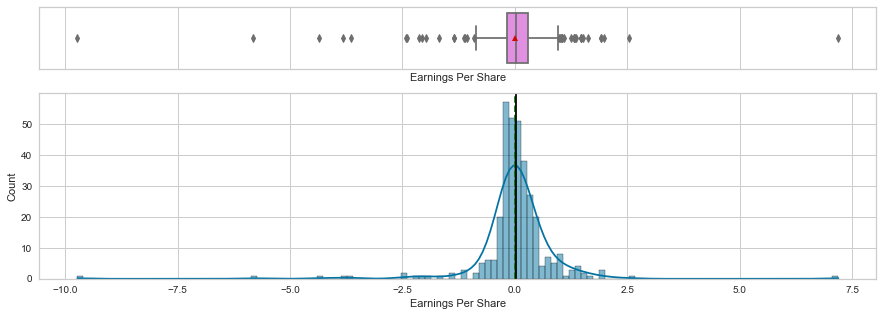

In [63]:
histogram_boxplot(subset_scaled_df, "Earnings Per Share", kde=True, figsize=(15, 5))

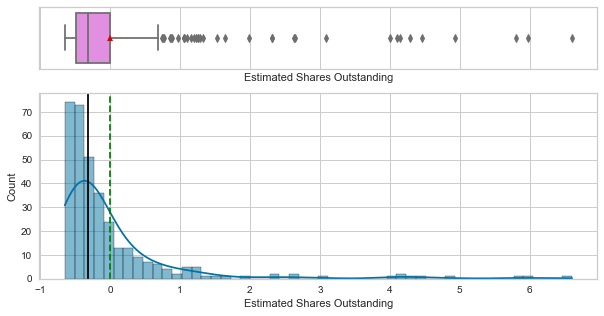

In [64]:
histogram_boxplot(subset_scaled_df, "Estimated Shares Outstanding", kde=True, figsize=(10, 5))

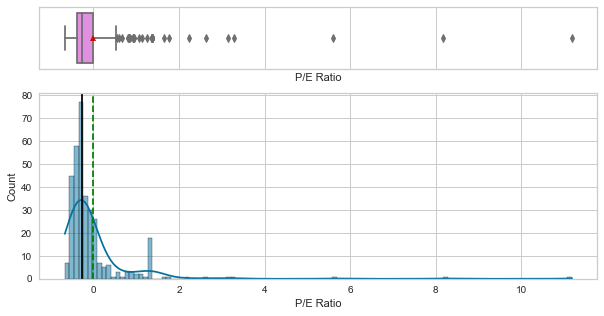

In [65]:
histogram_boxplot(subset_scaled_df, "P/E Ratio", kde=True, figsize=(10, 5))

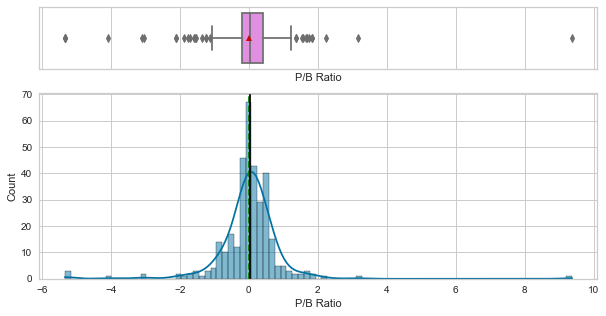

In [66]:
histogram_boxplot(subset_scaled_df, "P/B Ratio", kde=True, figsize=(10, 5))

Scaled data looks as one expects. 

## K-means Clustering

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.377354137922532
Number of Clusters: 3 	Average Distortion: 2.2652173220958
Number of Clusters: 4 	Average Distortion: 2.177016653596875
Number of Clusters: 5 	Average Distortion: 2.1219112607709603
Number of Clusters: 6 	Average Distortion: 2.0623419277260444
Number of Clusters: 7 	Average Distortion: 2.014527526380015
Number of Clusters: 8 	Average Distortion: 1.9775191681554642
Number of Clusters: 9 	Average Distortion: 1.9249206079144539
Number of Clusters: 10 	Average Distortion: 1.8526627658363244
Number of Clusters: 11 	Average Distortion: 1.8033369922850133
Number of Clusters: 12 	Average Distortion: 1.7706493820312894
Number of Clusters: 13 	Average Distortion: 1.7143427502653046
Number of Clusters: 14 	Average Distortion: 1.6708565405049682
Number of Clusters: 15 	Average Distortion: 1.6573548002212597


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

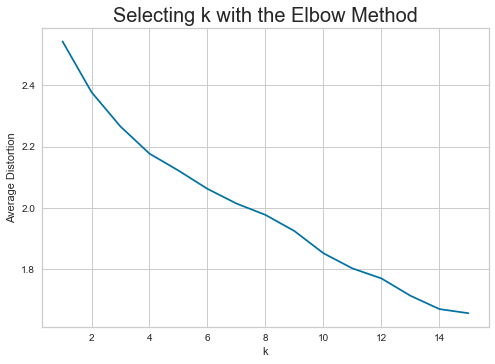

In [305]:
clusters = range(1, 16)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

Conclusion - it seems based on the Elbow method number of clusters s 4 (maybe 8 and maybe 12). 
There are 11 industry sectors so I will consider all 3 possibilities.

Now I check the Elbow methd using KElbowVisualizer from Yellowbrick library


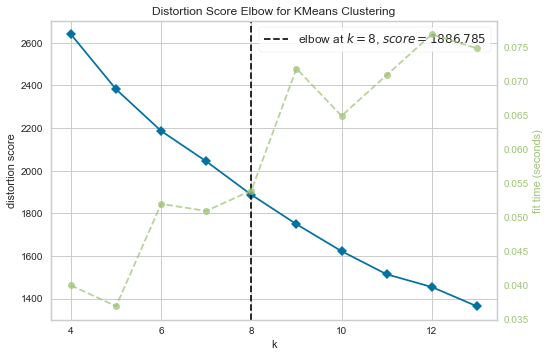

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [173]:
model1 = KMeans()
visualizer = KElbowVisualizer(model1, k=(4,14))

visualizer.fit(subset_scaled_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Conclusion - both Elbow mehtod visualization show that 8 is possible value for clusters.

No I check the silhouette score

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). 

1) The Silhouette coefficient of +1 indicates that the sample is far away from the neighboring clusters.

2) The Silhouette coefficient of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters.

3) Silhouette coefficient <0 indicates that those samples might have been assigned to the wrong cluster or are outliers.

For n_clusters = 2, silhouette score is 0.43969639509980457
For n_clusters = 3, silhouette score is 0.4644405674779404
For n_clusters = 4, silhouette score is 0.45483520750820555
For n_clusters = 5, silhouette score is 0.42436843176418354
For n_clusters = 6, silhouette score is 0.4016347402481329
For n_clusters = 7, silhouette score is 0.3910569923991079
For n_clusters = 8, silhouette score is 0.4012847345639638
For n_clusters = 9, silhouette score is 0.3287351008715512
For n_clusters = 10, silhouette score is 0.21883608483523762
For n_clusters = 11, silhouette score is 0.17134827418407605
For n_clusters = 12, silhouette score is 0.12221123012822241
For n_clusters = 13, silhouette score is 0.1383356181005985
For n_clusters = 14, silhouette score is 0.17475973570142375
For n_clusters = 15, silhouette score is 0.17492157492305108
For n_clusters = 16, silhouette score is 0.14967263837129005
For n_clusters = 17, silhouette score is 0.14264999399938652
For n_clusters = 18, silhouette score 

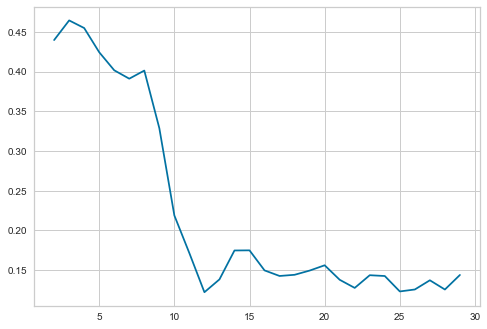

In [175]:
sil_score = []
cluster_list = list(range(2, 30))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

Conclusion - the best range for cluster number  seems to be 3-8. If I would guess from this figure then 3 or 7,8 look like best options.But I will compare the cases fom 3 to 8 clusters below to pick the best case. 
(Please note that this plot changes when I re-run it so it depends on initial data). 

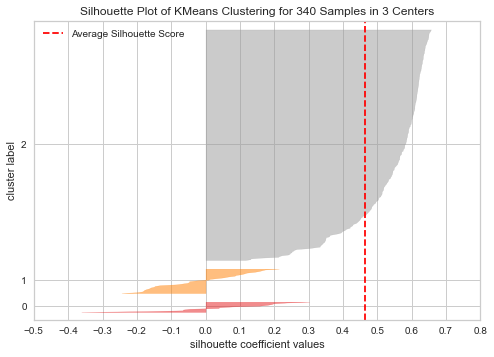

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [176]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

Negative  Silhouette coefficient values for 2 out of 3 clusters is  rather poor clustering example

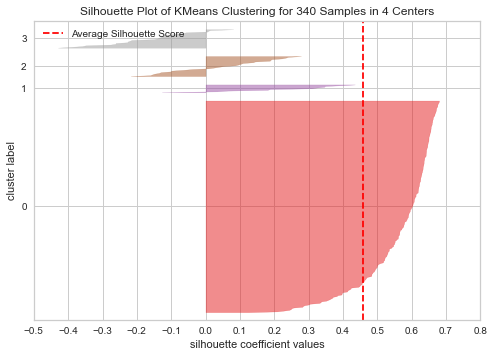

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [177]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

Negative values for silhoutette coefficient for 3 outof 4 clusters - example of poor results again. 

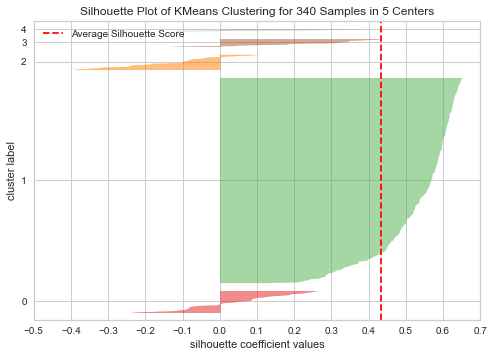

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [178]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

Similarly poor clustering. 

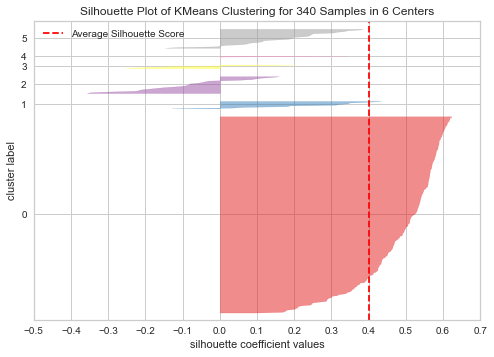

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [179]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

Still one big cluster and many small clusters with negative values of silhoutte coefficient. Not a good result. 

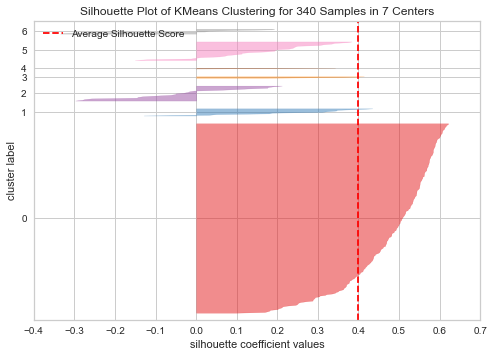

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [180]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

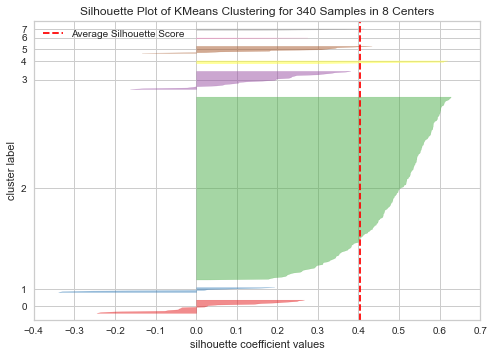

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [306]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(8, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

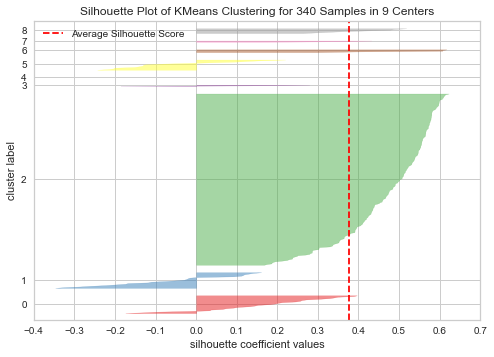

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [182]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(9, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

I add one more example for k=12 clusters.I do not expect good results here.

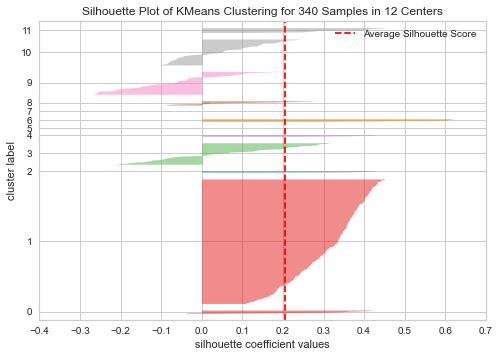

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 12 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [183]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(12, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

## Conclusion: It seems the best is k=8 clusters. I will also consider 3 cluster case for cluster profiling. All of the attempts had negative silhouette sections which one can attribute to outliers.

Comment: All of the clustering cases have instances with negatic silhuette score so I cannot with K-means clustering 
    get a a better separation of clusters with the data provided. It might be due to outliers or due to high 
    dimensionality. 
    I can try 
    1) remove outliers - but this is original data and there are not too many rows so I do not expect better results if I 
    drop data 
    2) PCA and clusters using features that are not dependent. 
    3) focus on few features. 
    
  For comparison I show silhuette plot for one of the larger number of clusters(k=12).

As one can see the results arenot getting better with the larger number of clusters.

All have portion with negative silhuette. The smalles negative portion have 3 and 8 clustering cases. 

In [184]:
data2=subset_scaled_df.copy()

## Cluster profiling

## Case 1 : Number of clusters =3

I start with K-mean clustering for 3 clusters.

In [185]:
kmeans3 = KMeans(n_clusters=3, random_state=0)
kmeans3.fit(data2)

KMeans(n_clusters=3, random_state=0)

In [186]:
data1=data.copy()

In [187]:
# adding kmeans cluster labels to the original dataframe
data1["K_clust"] = kmeans3.labels_

In [188]:
cluster_profile = data1.groupby("K_clust").mean()

In [189]:
cluster_profile["count_in_each_segments"] = (
    data1.groupby("K_clust")["Current Price"].count().values
)

In [190]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

The largest cluster (denoted as 0) containing 293 companies has the highest average price and the highest 'earnings per share'

The Two remaining clusters are smaller cluster denoted as 1 has 14 companies and the cluster denotes as 2 has 33 companies.

Cluster 1 has the highest average price change and the by far largest cash ratio and net cash flow, net income and estimated shares outstanding. This cluster has slightly lower average earnings per share. 

Cluster 2 has the highest average volatility, ROE P/ERato and P/B Ratio, but negative price change, net income (with positive net cash flow) and earnings per share. 

Cluster2 seems to group companies that have the highest volatility and for the period consdered these companies brought losses to the investors but judging from P/E ratio these companies represnt high relative value for investors. 

I have checked that cluster number 2 is dominated by companies that belong to Energy sector.


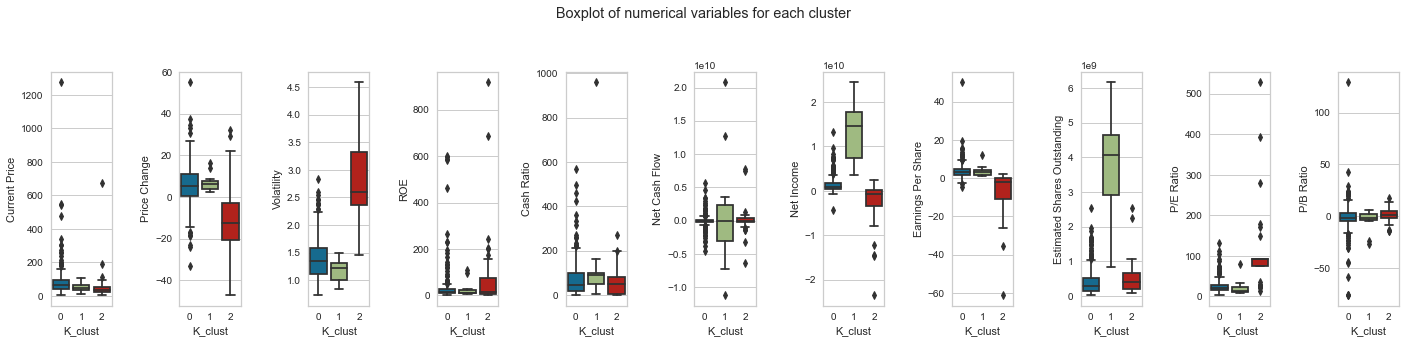

In [101]:
fig, axes = plt.subplots(1, 11, figsize=(20, 5))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(11):
    sns.boxplot(ax=axes[ii], y=data1[num_col[counter]], x=data1["K_clust"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [191]:
scaled=subset_scaled_df.copy()

In [192]:
# adding kmeans cluster labels to the original dataframe
scaled["K_clust"] = kmeans3.labels_

In [193]:
scaled

Current Price  Price Change  Volatility       ROE  Cash Ratio  \
0        -0.393341      0.493950    0.272749  0.989601   -0.210698   
1        -0.220837      0.355439    1.137045  0.937737    0.077269   
2        -0.367195      0.602479   -0.427007 -0.192905   -0.033488   
3         0.133567      0.825696   -0.284802 -0.317379    1.218059   
4        -0.260874     -0.492636    0.296470 -0.265515    2.237018   
..             ...           ...         ...       ...         ...   
335      -0.486181      0.901646    0.540121 -0.255142    4.308162   
336      -0.289510     -1.065766   -0.079703  1.062211   -0.476513   
337       0.221913      0.439539   -0.206067 -0.400362    0.332009   
338      -0.547053     -0.436811   -0.097813 -0.369243    0.320933   
339      -0.336453      1.051046    0.142671 -0.078803   -0.055639   

     Net Cash Flow  Net Income  Earnings Per Share  \
0        -0.339355    1.554415            1.309399   
1        -0.002335    0.927628            0.056755   
2         0.454058    0.744371            0.024831   
3        -0.152497   -0.219816           -0.230563   
4         0.133564   -0.202703           -0.374982   
..             ...         ...                 ...   
335      -0.559673   -1.487784           -1.127481   
336       0.053235   -0.051186            0.029391   
337       0.164889   -0.342467           -0.303532   
338      -0.051022   -0.301171           -0.239684   
339       0.111378   -0.293666           -0.318734   

     Estimated Shares Outstanding  P/E Ratio  P/B Ratio  K_clust  
0                        0.107863  -0.652487  -0.506653        0  
1                        1.250274  -0.311769  -0.504205        0  
2                        1.098021  -0.391502   0.094941        0  
3                       -0.091622   0.947148   0.424333        0  
4                        1.978399   3.293307   0.199196        2  
..                            ...        ...        ...      ...  
335                      0.429111  -0.082116   0.572194        0  
336                     -0.167741  -0.337154  -0.152012        0  
337                     -0.460058   2.233634  -1.589390        0  
338                     -0.377852  -0.222714   0.118680        0  
339                     -0.092942   0.854902   0.246754        0  

[340 rows x 12 columns]

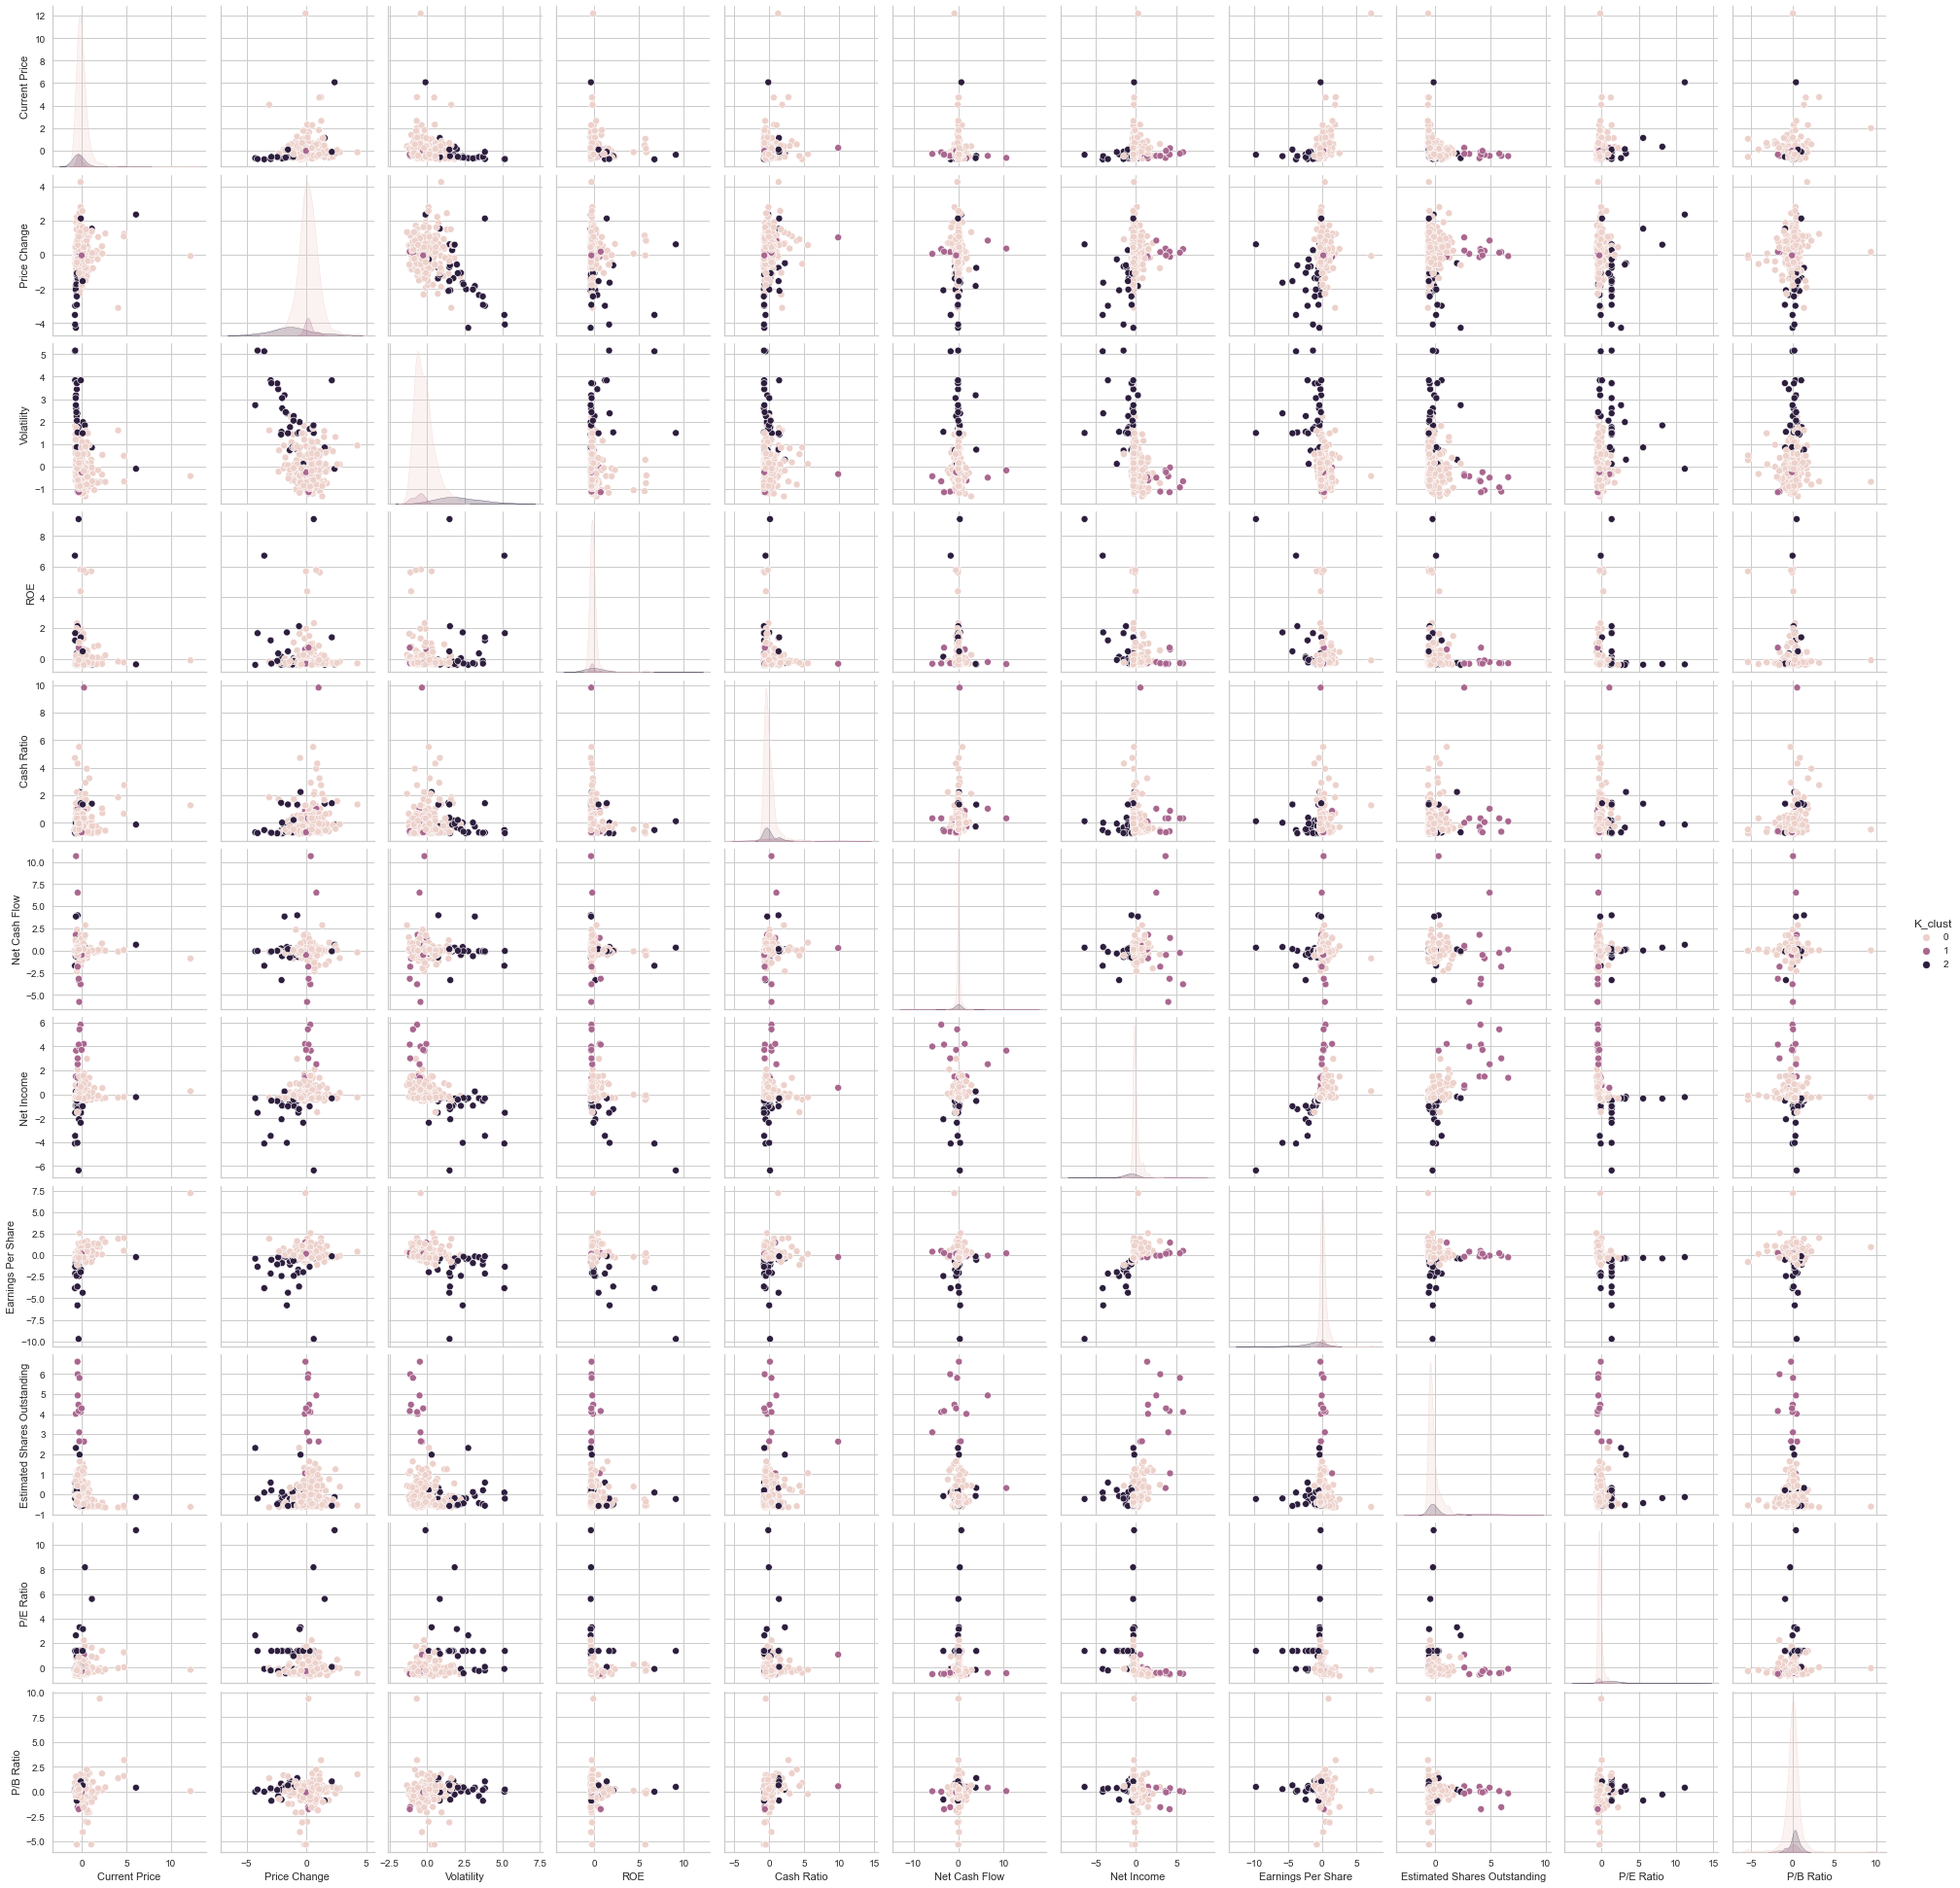

In [105]:
sns.pairplot(scaled,hue='K_clust') 

Pairplot shows  scatterplots with cluster separated data for given 2 variables.  

Comment: Pairplot show we have overlapping clusters. Becaus of that onemight not get good value for metrics 
    related to separation of clusters. I will later try bigger number of clusters. 

I plot now boxplots for numerical variables using scaled dataframe data.

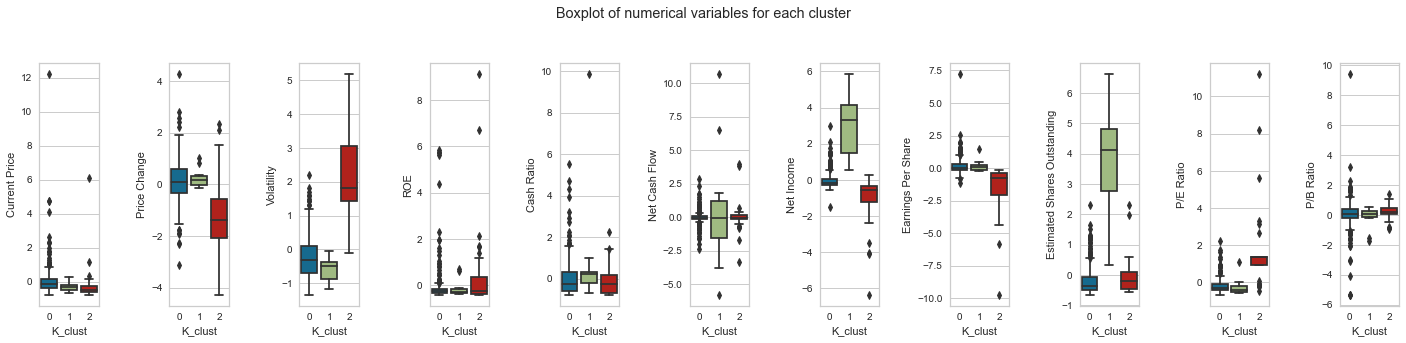

In [108]:
fig, axes = plt.subplots(1, 11, figsize=(20, 5))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(11):
    sns.boxplot(ax=axes[ii], y=scaled[num_col[counter]], x=scaled["K_clust"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

I caclulate averages for each sector in each cluster.

In [194]:
data1.groupby(["K_clust","GICS Sector"]).mean()

Current Price  Price Change  Volatility  \
K_clust GICS Sector                                                            
0       Consumer Discretionary          117.963409      4.585968    1.551689   
        Consumer Staples                 73.584629      8.788763    1.167273   
        Energy                           79.936001     11.130011    1.720136   
        Financials                       59.674000      3.615182    1.273660   
        Health Care                     136.246944      9.673223    1.544631   
        Industrials                      75.453380      3.207463    1.387425   
        Information Technology           64.691481      8.343370    1.547724   
        Materials                        80.224211      7.551575    1.712532   
        Real Estate                      90.976925      6.205548    1.206053   
        Telecommunications Services      28.063334      7.521827    1.668675   
        Utilities                        52.968542      0.803657    1.118018   
1       Consumer Discretionary           14.090000      2.398256    1.151454   
        Consumer Staples                 42.959999      6.812526    0.889913   
        Energy                           77.949997      3.656915    1.370062   
        Financials                       47.242500      6.680426    1.195196   
        Health Care                      62.096667      4.283889    1.337090   
        Information Technology           69.555003     15.129708    1.273314   
        Telecommunications Services      40.315000      6.109710    0.851017   
2       Consumer Discretionary          372.540008     30.882323    2.627585   
        Energy                           37.651667    -15.256485    2.795523   
        Health Care                     190.750000     22.338380    2.022921   
        Industrials                      20.250000    -16.632362    2.954291   
        Information Technology           52.829999     -4.338430    2.609567   
        Materials                         6.770000    -31.685167    3.796410   

                                            ROE  Cash Ratio  Net Cash Flow  \
K_clust GICS Sector                                                          
0       Consumer Discretionary        43.027027   45.513514  -3.722697e+07   
        Consumer Staples              92.777778   70.777778   3.646065e+08   
        Energy                        18.400000   39.000000  -7.792000e+08   
        Financials                    27.822222   98.555556   2.379658e+08   
        Health Care                   27.500000  101.638889   1.732364e+08   
        Industrials                   50.923077   36.673077  -1.619947e+08   
        Information Technology        23.703704  124.222222  -2.198360e+08   
        Materials                     26.578947   43.631579  -2.939335e+08   
        Real Estate                   12.444444   50.111111   3.546704e+06   
        Telecommunications Services   14.333333  186.666667   1.753333e+08   
        Utilities                      9.875000   13.625000   1.764623e+08   
1       Consumer Discretionary        26.000000   43.000000   3.515000e+09   
        Consumer Staples              29.000000   74.000000  -1.649000e+09   
        Energy                         9.000000    7.000000  -9.110000e+08   
        Financials                     9.000000   99.000000   4.387500e+08   
        Health Care                   39.666667   99.000000   1.401667e+09   
        Information Technology        13.500000  560.000000   6.669500e+09   
        Telecommunications Services   60.000000   12.500000  -4.805000e+09   
2       Consumer Discretionary        89.000000  128.000000   6.154625e+08   
        Energy                       112.291667   55.500000  -1.851061e+08   
        Health Care                    2.000000  195.000000   6.600000e+07   
        Industrials                   10.000000   11.000000  -6.174400e+07   
        Information Technology        13.000000  117.500000   2.134710e+09   
      

Comment: Cluster 2 acros allsectors groups companies with highest volatility. It has the highest average price for Health care and consumer discretionary.
And only those 2 sectorshad positive price change. The companies from other sectors had negative price change. 
    
This feature suggests that maybe this cluster is not very homogenous  - since only when I look at 2 features the companies seem to fall into separate 2 groups. 

Comment: Cluster 0 has companies from all of the sectors. Cluster 1 has companies from 7 sectors. 
    cluster 2 has companies from 6 sectors with the biggest part of the cluster beloging to energy sector companies. 

## Case 2 : Number of clusters k=8

In [197]:
data8=data.copy()

In [199]:
scaled8=subset_scaled_df.copy()

In [200]:
kmeans8 = KMeans(n_clusters=8, random_state=0)
kmeans8.fit(scaled8)

KMeans(random_state=0)

Adding K-means labels to original dataframe

In [201]:
# adding kmeans cluster labels to the original dataframe
data8["K_clust"] = kmeans8.labels_

Analysis of cluster profiles

In [202]:
cluster_profile8 = data8.groupby("K_clust").mean()

In [203]:
cluster_profile8["No"] = (
    data8.groupby("K_clust")["Current Price"].count().values
)

In [204]:
# lets display cluster profile
cluster_profile8.style.highlight_max(color="lightgreen", axis=0)

In [205]:
data8.groupby(['K_clust','GICS Sector']).Security.count()

K_clust  GICS Sector                
0        Consumer Discretionary          2
         Health Care                     4
         Information Technology          1
         Real Estate                     1
1        Consumer Discretionary          3
         Consumer Staples                1
         Energy                          1
         Health Care                     5
         Information Technology          8
         Materials                       1
         Telecommunications Services     1
2        Consumer Discretionary         32
         Consumer Staples               15
         Energy                          5
         Financials                     44
         Health Care                    29
         Industrials                    50
         Information Technology         20
         Materials                      17
         Real Estate                    26
         Telecommunications Services     2
         Utilities                      24
3        Energy  

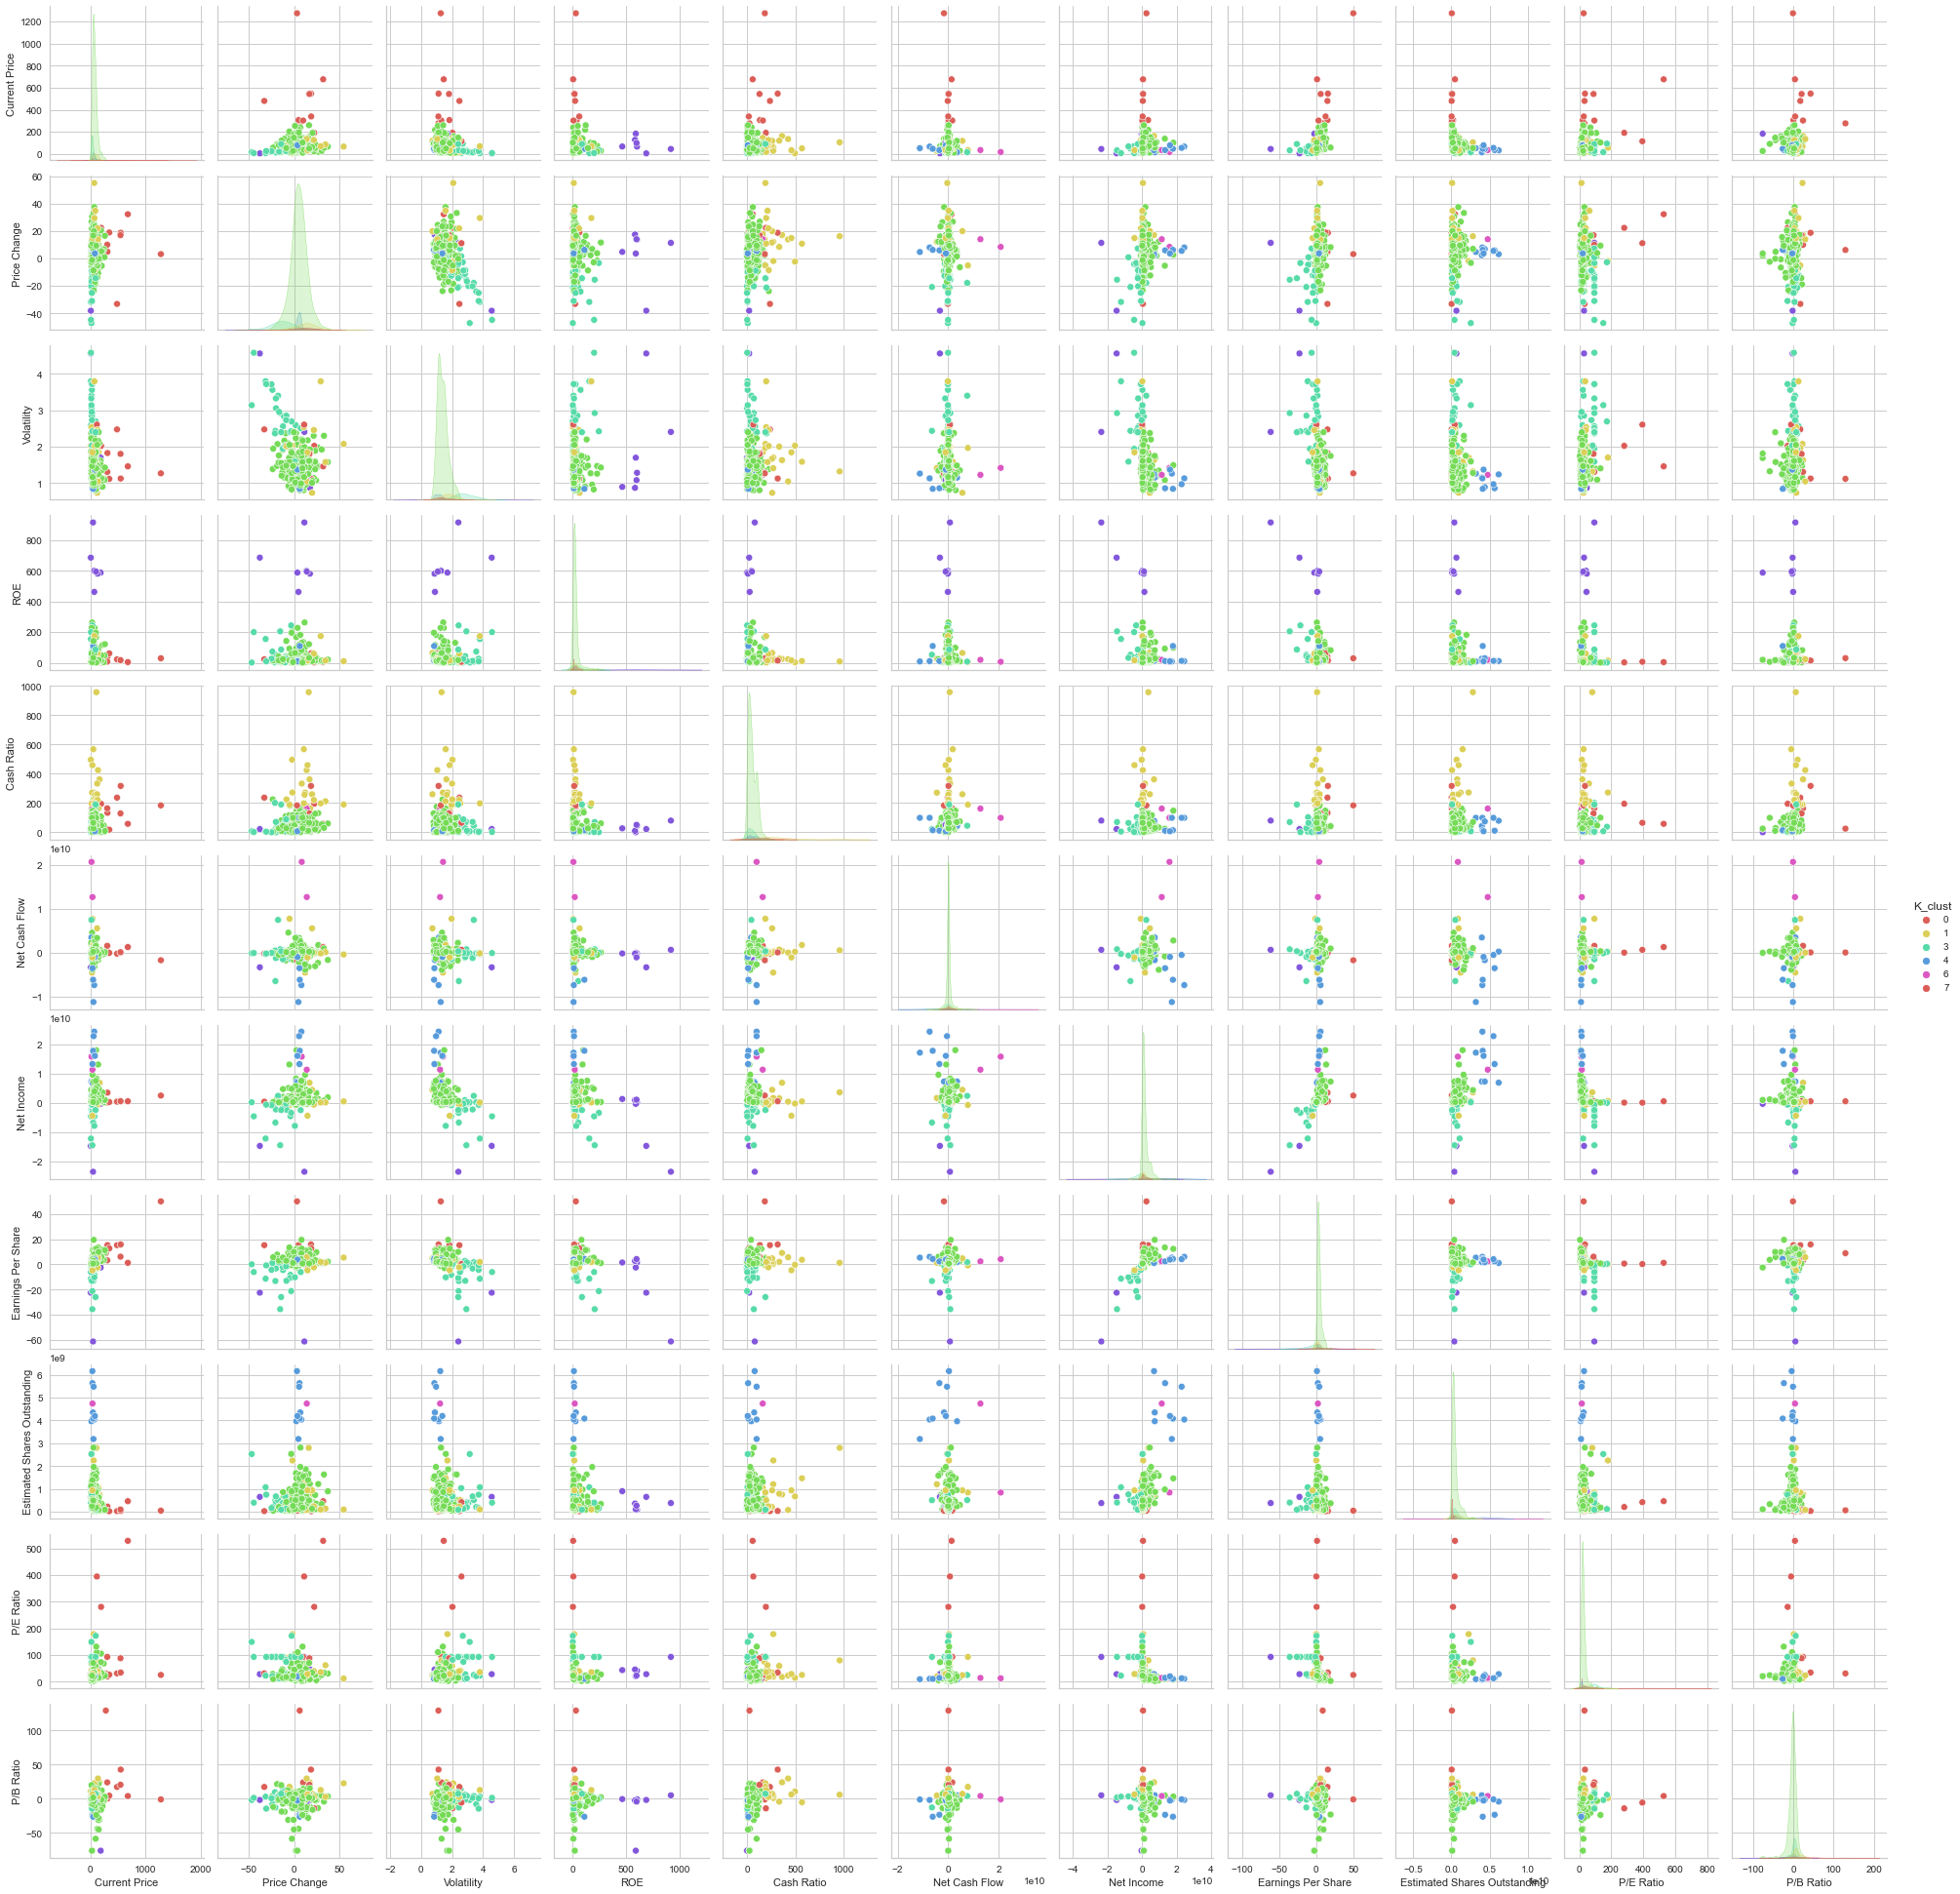

In [206]:
import warnings
warnings.filterwarnings('ignore')
sns.pairplot(data8,hue='K_clust',palette='hls') 

Comment: Negative P/B ratio means company can be in trouble: that means companies can have problems.

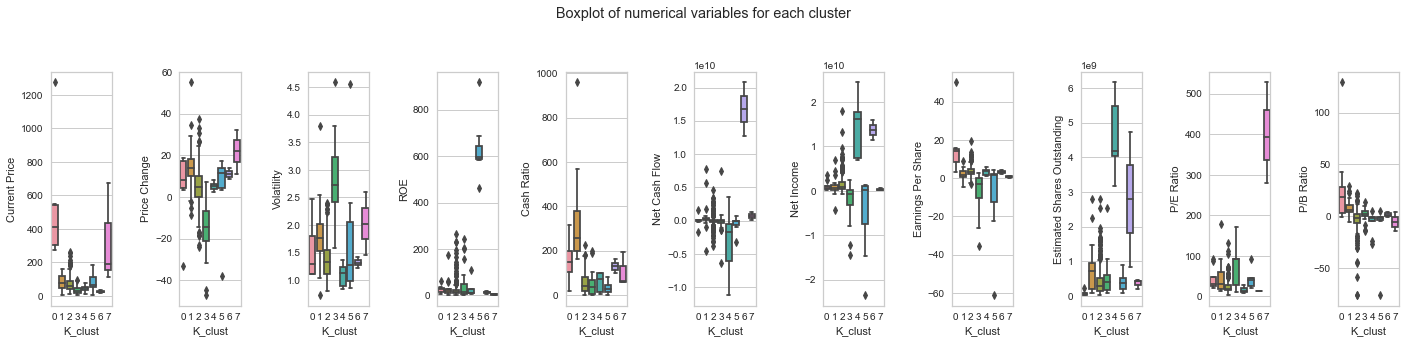

In [432]:
fig, axes = plt.subplots(1, 11, figsize=(20, 5))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(11):
    sns.boxplot(ax=axes[ii], y=data8[num_col[counter]], x=data8["K_clust"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

Comments about clusters:

1)  Cluster 0 has 8 companies that have the highest average price of 509 dollars, and the highest earnings per share 16 % and highest P/BRatio (30)  with modest price change of 6% and average volatility (1.5). Half of the companies belong to Health care sector.

2) Cluster 1 has 20 companies, highest Cash Ratio (322) with relatively large Price change and Current price close to overall average.The average price 80 dollars  is close the overall average price 81 dollars. Sectors mostly form Health care and IT

3) Cluster 2 has 264 companies and the average values of the features for this cluster are close to overall average values. Companies with average price and price change and volatility. The biggest value for this cluster is the number of companies.


4) Cluster 3 has 27 companies, mostly from Energy sector and this cluster has the highest volatility 2.8,large loss (per Price Changes) and relatiley low current price, with negative net cash flow, net income, Earnings per share. Because ofthe price change -16% - it is a group of the biggest drop of the price. 

5) Cluster 4 has 9 companies. The highest Net Income and Estimated shares outstanding. It has lowets average volatility and low current price while price change of 5 % is not far from overall average price change 4%. Has the lowest average P/B Ratio and lowest Net Income.

6) Cluster 5 has 7 companies, current price close to overall average, highest ROE.  It has price change lower than overal average price change. It has negative Net Cash Flow, Net Income, Earning per share and P/R Ratio. In this respect it is similar to another cluster - cluster 3. It seems the investors did not lose money but because of the negative indicators this cluster seem to be similar to biggest "loosers" cluster 3. 

7) Cluster 6 has 2 companies the largest Net Cash Flow, with lower  price but Price change - 2-3 times larger than overall average.  

8) Cluster 7 has 3 companies with the highest price change of 22% and P/E Ratio. High P/E ratio could mean the stock price is overvalued. It has relatively high volatility of 2 and average current price for this cluster 327 dollars - far larger than overall average price.  One should include the cluster in portfolio bt one has to be careful due to ROE and volatility.




Overall: It seems grouping seems more useful than when we had 3 clusters. One can analyse the market and make decision for investing for example build portoflio.  


In view of some linear dependence between the features and that some of the features have similar values for given sector it might be interesting to either 
1) remove the features that are sector dependent or 
2) add Sector-label (?).

I think also removing correlated variables or PCA might help to improve the K-means clustering for this case. 

In [207]:
scaledhc=subset_scaled_df.copy()

## Hierarchical Clustering

In [209]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]
high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(scaledhc, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(scaledhc))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9232271494002922.
Cophenetic correlation for Euclidean distance and complete linkage is 0.7873280186580672.
Cophenetic correlation for Euclidean distance and average linkage is 0.9422540609560814.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8693784298129404.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9062538164750717.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.598891419111242.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9338265528030499.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9127355892367.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9259195530524589.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.7925307202850003.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9247324030159737.
Cophenetic correl

In [210]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9422540609560814, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [211]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(scaledhc, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(scaledhc))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.9232271494002922.
Cophenetic correlation for complete linkage is 0.7873280186580672.
Cophenetic correlation for average linkage is 0.9422540609560814.
Cophenetic correlation for centroid linkage is 0.9314012446828154.
Cophenetic correlation for ward linkage is 0.7101180299865353.
Cophenetic correlation for weighted linkage is 0.8693784298129404.


In [212]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9422540609560814, which is obtained with average linkage.


Comment - still the highest cophenetic correlation coefficient is for average linkage.

**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**

**Let's see the dendrograms for the different linkage methods.**

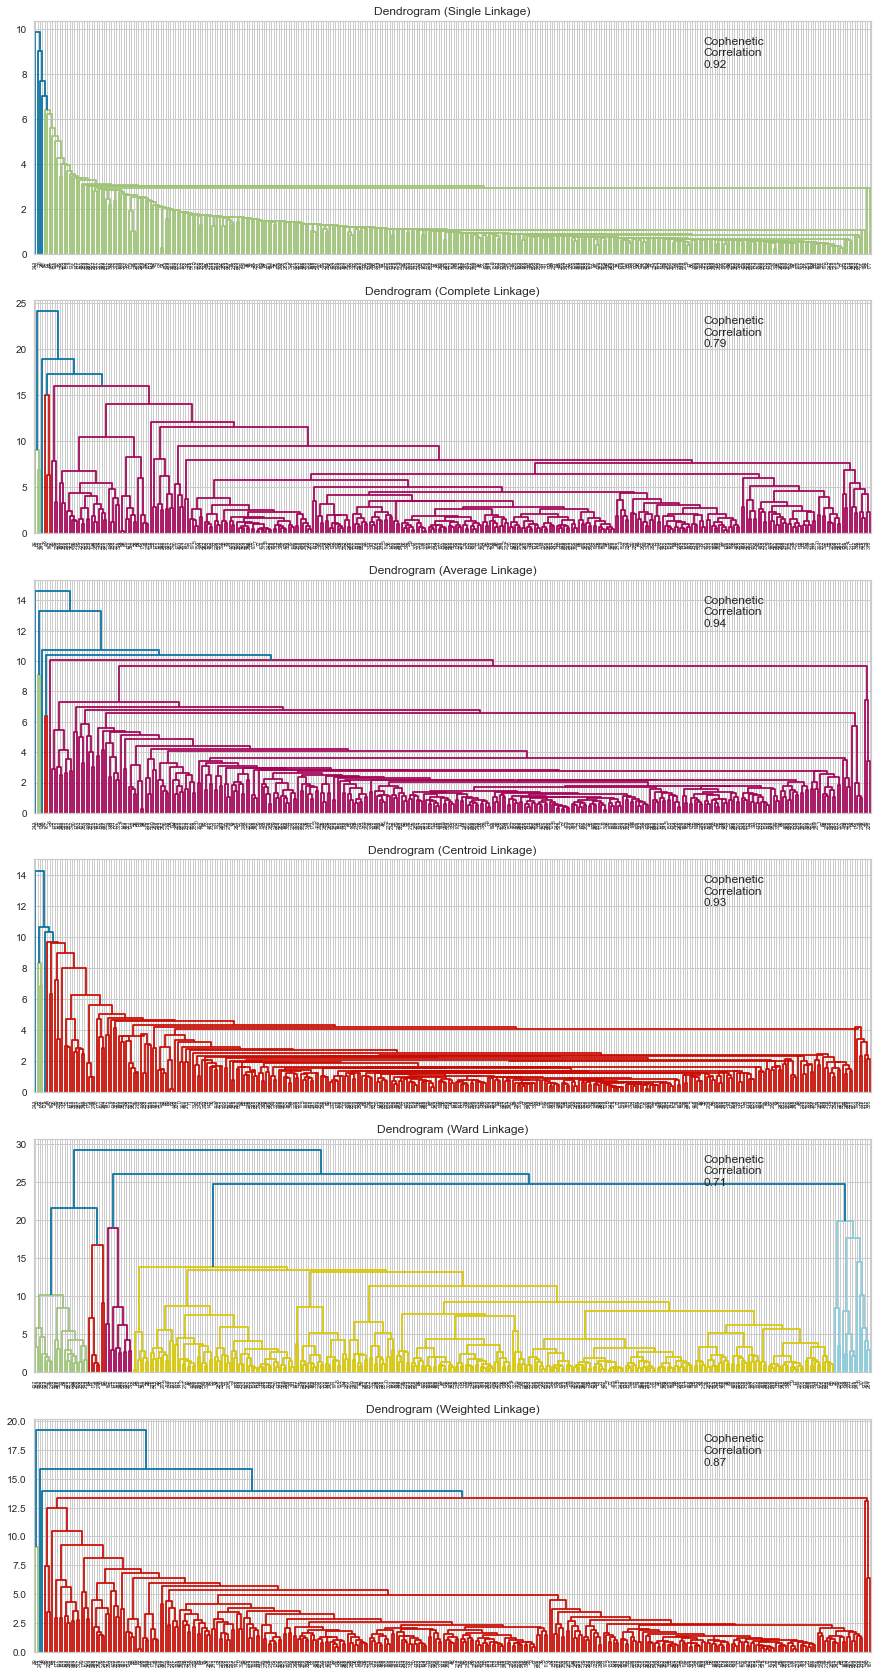

In [213]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(scaledhc, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(scaledhc))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations from dendrograms**

- The cophenetic correlation is highest for average linkage method (0.94).
- We will move ahead with average linkage 
- 8-9 appears to be the appropriate number of clusters from the dendrogram for average linkage.

In [219]:
datahc8=data.copy()

In [220]:
HCmodel8 = AgglomerativeClustering(n_clusters=8, affinity="euclidean", linkage="average")
HCmodel8.fit(scaledhc)

AgglomerativeClustering(linkage='average', n_clusters=8)

In [217]:
scaledhc8=scaledhc.copy()

In [132]:
datahs=subset_scaled_df

In [231]:
datahc8["HC_Clust"] = HCmodel8.labels_
scaledhc8["HC_Clust"] = HCmodel8.labels_

Cluster profiling for 8 clusters

## Cluster profiling k-8

In [223]:
cluster_profile1 = datahc8.groupby("HC_Clust").mean()

In [224]:
cluster_profile2 = scaledhc8.groupby("HC_Clust").mean()

In [228]:
cluster_profile1["No_in_clust"] = (
    datahc8.groupby("HC_Clust")["ROE"].count().values
)

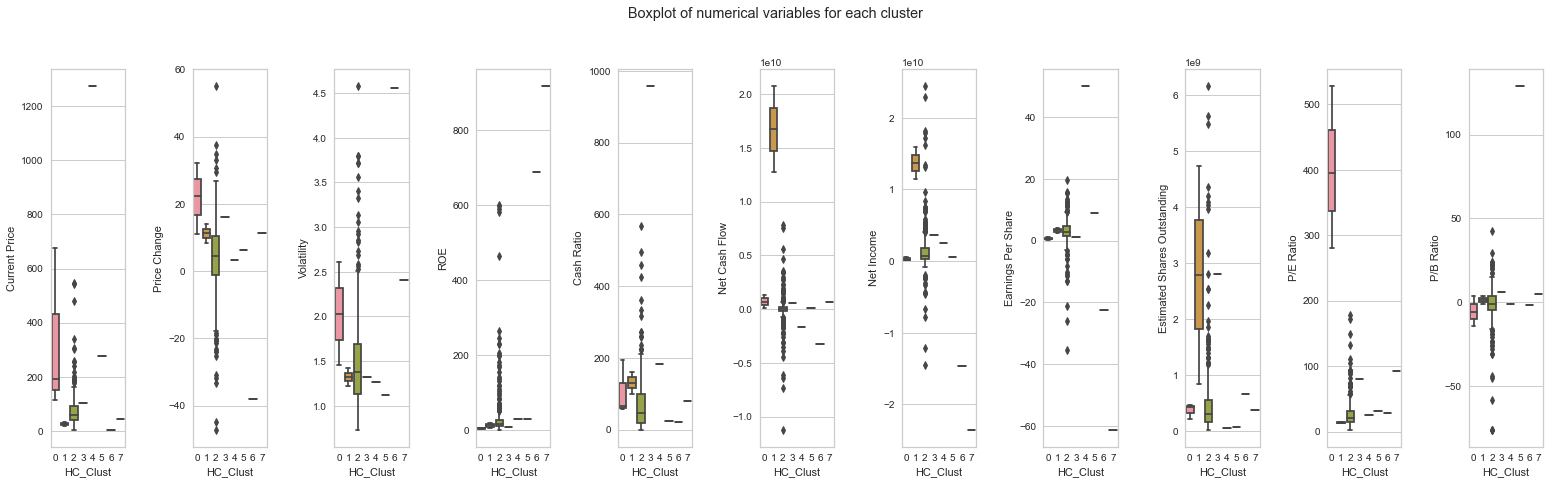

In [337]:
fig, axes = plt.subplots(1, 11, figsize=(22, 7))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(11):
    sns.boxplot(ax=axes[ii], y=datahc8[num_col[counter]], x=datahc8["HC_Clust"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

Checking for the structure of the clusters

In [226]:
datahc8.groupby(['HC_Clust','GICS Sector']).Security.count()

HC_Clust  GICS Sector                
0         Consumer Discretionary          1
          Health Care                     1
          Information Technology          1
1         Financials                      1
          Information Technology          1
2         Consumer Discretionary         38
          Consumer Staples               19
          Energy                         28
          Financials                     48
          Health Care                    39
          Industrials                    53
          Information Technology         29
          Materials                      20
          Real Estate                    27
          Telecommunications Services     5
          Utilities                      24
3         Information Technology          1
4         Consumer Discretionary          1
5         Information Technology          1
6         Energy                          1
7         Energy                          1
Name: Security, dtype: int64

We have one big cluster with 330 companies and the rest of the clusters has 1 company and one cluster has 2 companies and one 3. Hierarchical clustering seems for this data worse than the k-means clustering and I did not expect that. It is difficult to imagine what could go wrong here. 

In [230]:
# lets display cluster profile
cluster_profile1.style.highlight_max(color="lightgreen", axis=0)

Conclusion:  have started with 8 clusters as this ws the best case for K-means clustering. 

In the case of K-means clustering with 8 clusters - we had clusters that were more mixed.

Now we have one big cluster with averages for featuresclose to overall averages and one cluster with 3 companies one with 2 and 5 with one company. The single company clusters are the clusters with e.g. highest Current Price or highest volatility or highest Cash Ratio and the highest ROE

So we have the clustering method selecting only "highest price" (culster -company 4) and "highest volatility"+lowest price drop (cluster-company 6) or "largest price change" (cluster 0), "Largest ROE" (cluster) companies and put it as separate clusters. In this sense the method of hierarchical clustering worked like method detecting outliers. 


This method did not seem to work well. It might be that we have too many features or the correlations between features play role and the clustering only finds outliers at this point. On the pair plots onecould see that for K-means the clusters were overlapping. This often means PCA can help to 


What I think is worth a try before PCA is 
- Internet suggests a method independent of outliers (K-medoids and DBSCAN).
- And I will try Ward linkage as this seems have more clusters that are not a single company cluster. And is less dependent on outliers. 
- feture selection removing correlated features - based on correlation matrix (it is like a step before PCA)
- looking at seaborn pairplots from k-means clustering I believe one can pick the features which clustered there better(less overlap between clusters) and check k-means and agglomerative clustering again - for this subset of features (if we do not change features to PCA  new features then the overlapping of the clusters vvisible on pair plots will be a problem for most of the methods).  




## 9 cluster hierarcical clustering 

In [232]:
HCmodel9 = AgglomerativeClustering(n_clusters=9, affinity="euclidean", linkage="average")
HCmodel9.fit(scaledhc)

AgglomerativeClustering(linkage='average', n_clusters=9)

In [218]:
scaledhc9=scaledhc.copy()

In [221]:
datahc9=data.copy()

In [233]:
datahc9["HC_Clust"] = HCmodel9.labels_
scaledhc9["HC_Clust"] = HCmodel9.labels_

## Cluster profiling k=9

In [234]:
cluster_profile19 = datahc9.groupby("HC_Clust").mean()

In [235]:
cluster_profile29 = scaledhc9.groupby("HC_Clust").mean()

In [236]:
cluster_profile19["No_in_clust"] = (
    datahc9.groupby("HC_Clust")["ROE"].count().values
)

This is not getting better for 9 clusters - we have one cluster with 330 companies 2 with 2 companies and 6 - single companies clusters.

I will explore the single company clusters n more detail below.

In [238]:
# lets display cluster profile
cluster_profile19.style.highlight_max(color="lightgreen", axis=0)

In [290]:
print(datahc9.loc[datahc9['HC_Clust'] > 0])

    Ticker Symbol                 Security             GICS Sector  \
6             ADS    Alliance Data Systems  Information Technology   
19           ALXN  Alexion Pharmaceuticals             Health Care   
26           AMZN           Amazon.com Inc  Consumer Discretionary   
30            APA       Apache Corporation                  Energy   
40            BAC     Bank of America Corp              Financials   
62            CHK        Chesapeake Energy                  Energy   
125            FB                 Facebook  Information Technology   
167          INTC              Intel Corp.  Information Technology   
226          NFLX             Netflix Inc.  Information Technology   
243          PCLN        Priceline.com Inc  Consumer Discretionary   

                         GICS Sub Industry  Current Price  Price Change  \
6    Data Processing & Outsourced Services     276.570007      6.189286   
19                           Biotechnology     190.750000     22.338380   
26  

Alexion is subsidiary of Astra Zeneca, which among others recently was on the news as vaccine producent 

Amazon, Netlix, Bank of America, Facebook and Intel - are the companies in "their own clusters".Funny they are related to 
ML/AI. 

Chesapeak is and Energy company that is losing value on stock market due to the lowe/falling oil prices.

Alliance Data Systems Corporation is a publicly traded provider of loyalty and marketing services, such as private label credit cards, coalition loyalty programs, and direct marketing, derived from the capture and analysis of transaction-rich data.

Alliance and Prceline belong to Internet & Direct Marketing Retail Sector. 

Conclusion - increasing the number of clusters does not change the overal structure - it seems rather the 3 companies cluster from previous (8 cluster) method got split. 
It seems to be working even more like outlier detector. 

BUT the clustering works at the moment - it detect a special companies with exceptional data - companies that are either excellent to invest in or should be avoided.  

## 8 clusters hierarchical clustering Ward linkage 

In [239]:
data8w=data.copy()

In [241]:
scaled8w=subset_scaled_df.copy()

In [242]:
HCmodel8W = AgglomerativeClustering(n_clusters=8, affinity="euclidean", linkage="ward")
HCmodel8W.fit(scaled8w)

AgglomerativeClustering(n_clusters=8)

In [243]:
data8w["HC_Clust"] = HCmodel8W.labels_
scaled8w["HC_Clust"] = HCmodel8W.labels_

In [244]:
cluster_profile1 = data8w.groupby("HC_Clust").mean()
cluster_profile2 = scaled8w.groupby("HC_Clust").mean()

In [245]:
cluster_profile2["No_in_clust"] = (
    scaled8w.groupby("HC_Clust")["ROE"].count().values
)
cluster_profile1["No_in_clust"] = (
    data8w.groupby("HC_Clust")["ROE"].count().values
)


In [246]:
# lets display cluster profile
cluster_profile1.style.highlight_max(color="lightgreen", axis=0)

This method is a bit better.We have one big cluster of 285 companies and one with 22 companies and one with 9 one with 7, 2 clusters with 6 companies, one with 3 and one with 2.

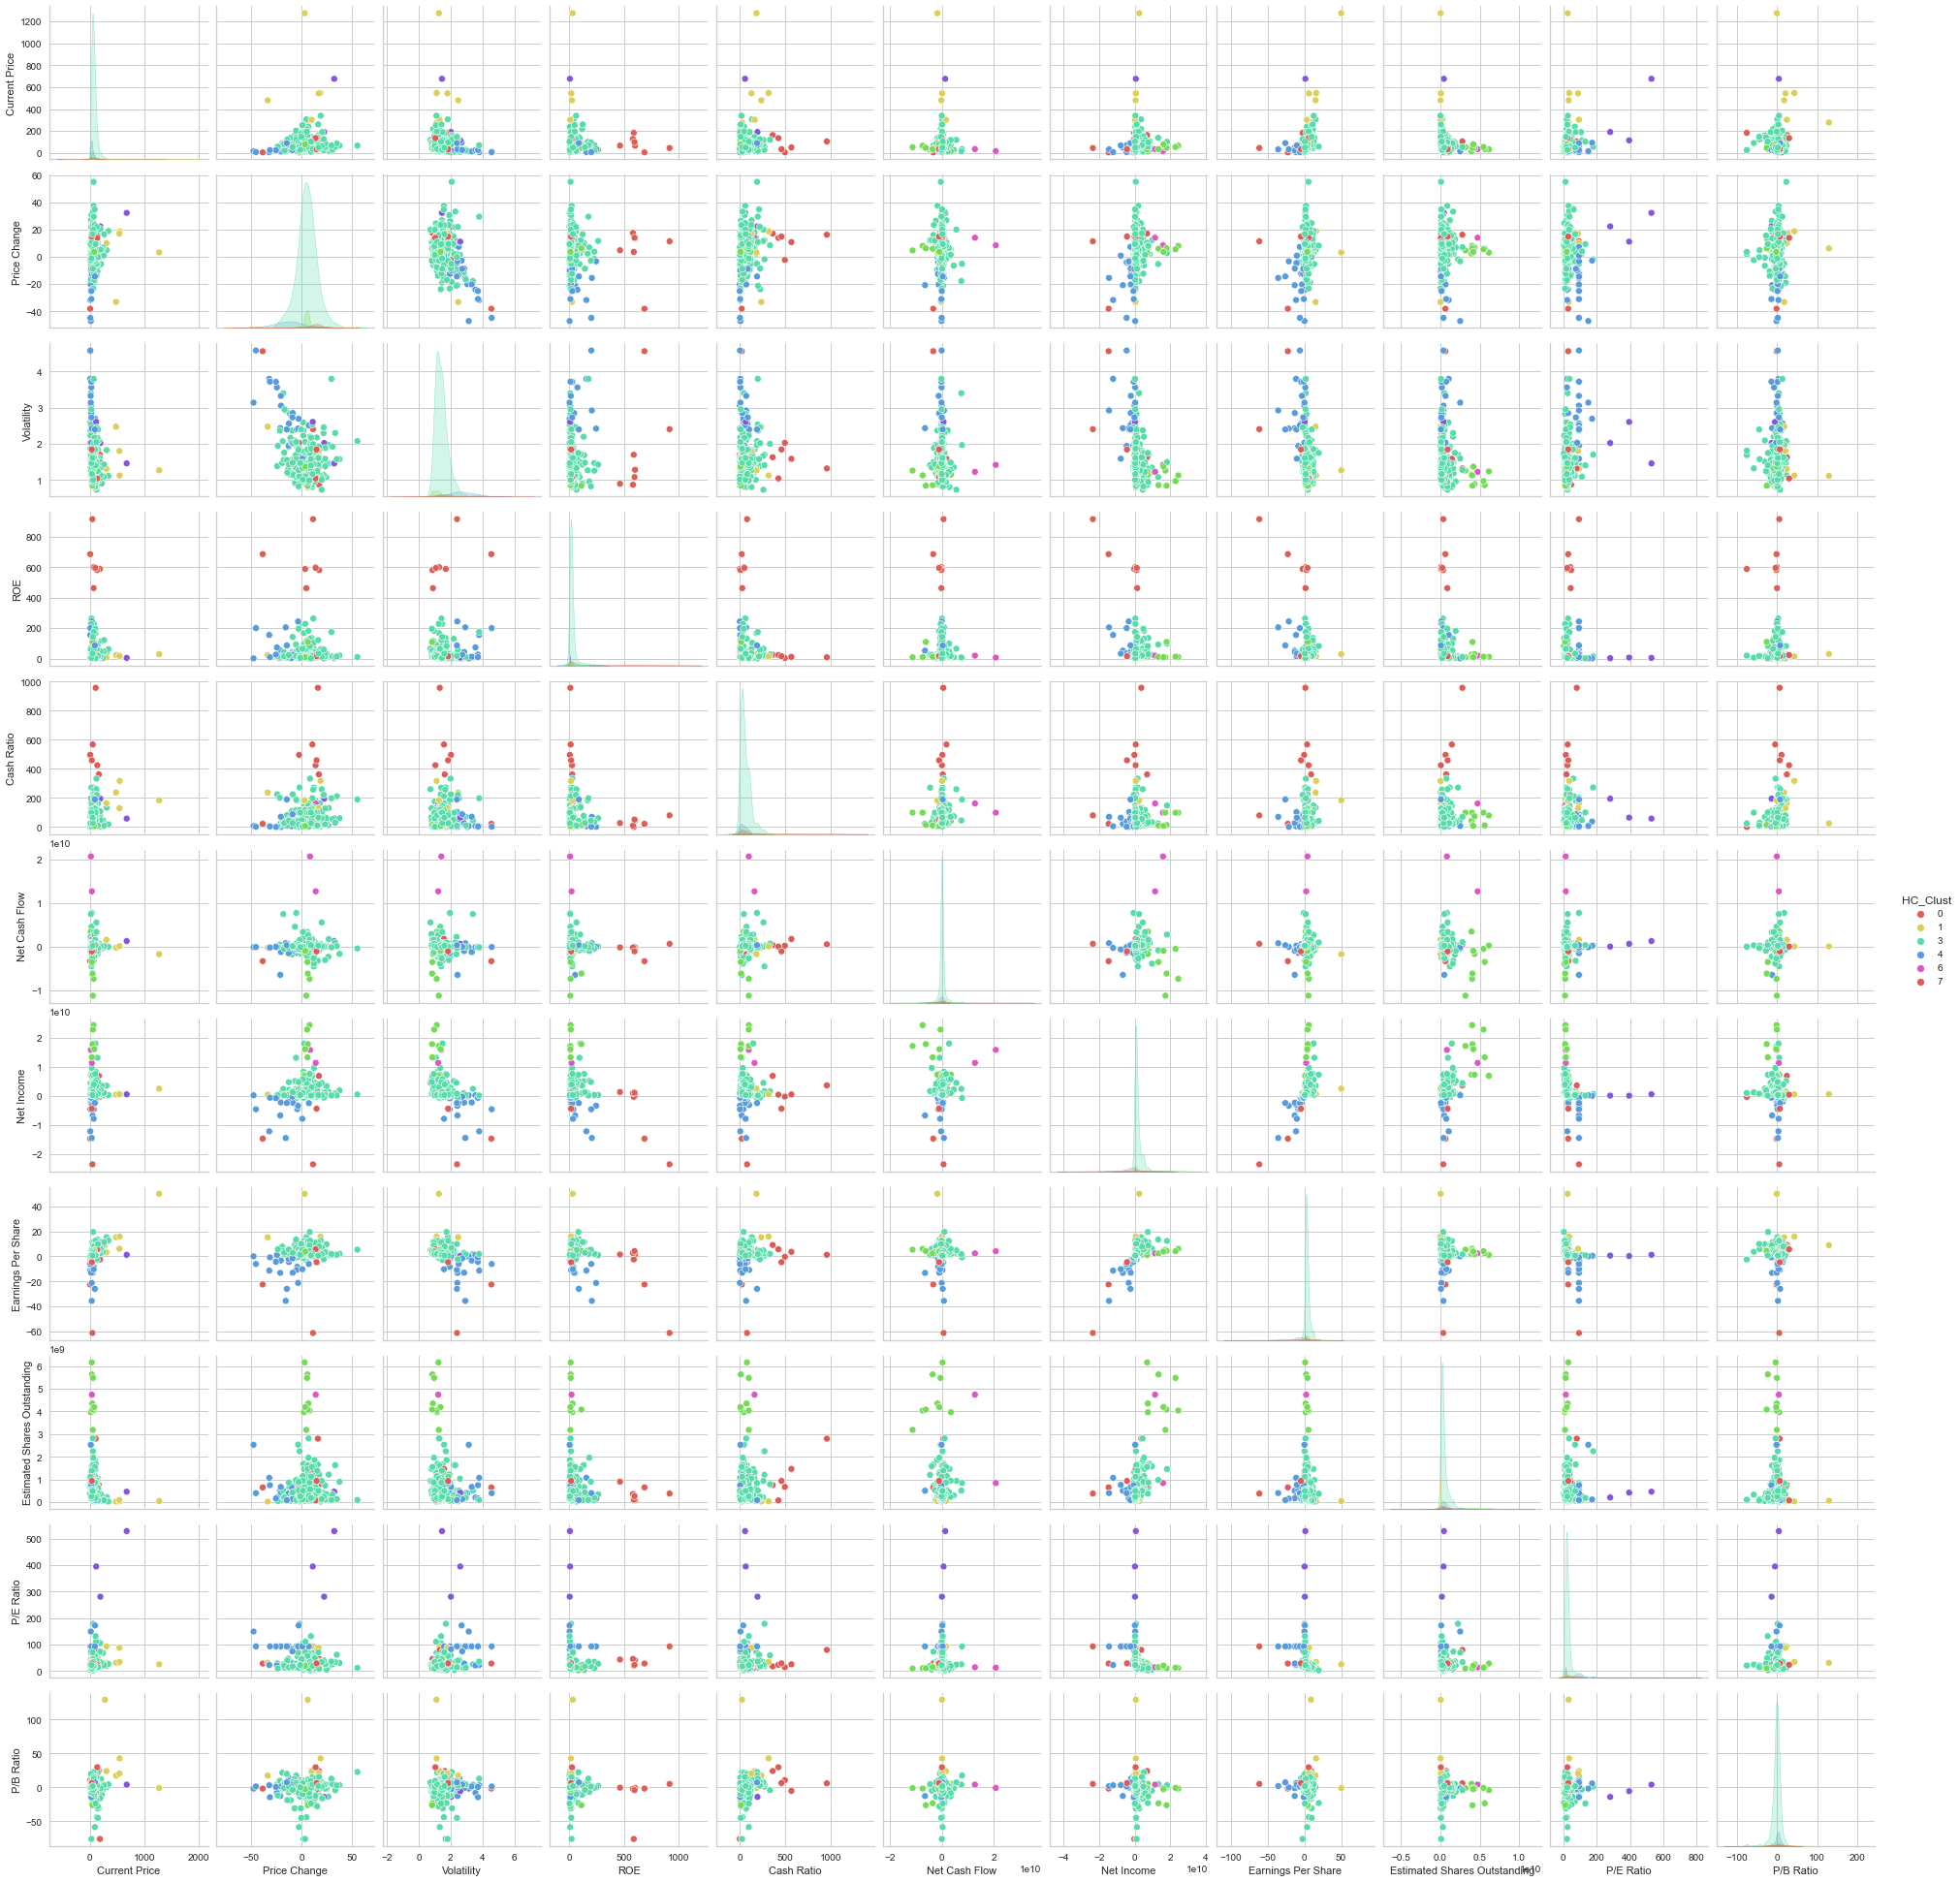

In [249]:
import warnings
warnings.filterwarnings('ignore')
sns.pairplot(data8w,hue='HC_Clust',palette='hls')

## Removing  Outliers

Comment 1: According to https://medium.com/analytics-vidhya/effect-of-outliers-on-k-means-algorithm-using-python-7ba85821ea23 outliers can affect k-means clustering (Euclidean distance) - outliers can group as separate cluster or they can cause other clusters to merge. One can consider method less sensitive to outliers such as k medians or use DBSCAN.

Comment 2: Agglomerative clustering can use various measures to calculate distance between two clusters, which is then used to decide which two clusters to merge.

Two popular approaches are single-link and complete-link. There seems to be some discrepancy in whether single-link or complete-link is sensitive to outliers. I am stating a few examples below but I am sure that there are many more.

(1) Stanford NLP IR book states "[complete-link] causes sensitivity to outliers".

(2) Chapter 8 in the Data Mining book by Tan and Kumar says the following in the section 8.3.2:

"The single link technique is good at handling non-elliptical shapes, but is sensitive to noise and outliers."

"Complete link is less susceptible to noise and outliers, but it can break large clusters and it favors globular shapes."

(3) The Applied Multivariate Statistics book says :

"... single link method which is also very sensitive to errors of measurement, but somewhat robust to outliers. The complete link and Ward’s method tend to find compact clusters of nearly equal size with the clustering solution adversely affected by outliers."


In [250]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [252]:
datan=data.copy()

In [259]:
df=remove_outlier(datan,"Current Price")

In [264]:
df1=remove_outlier(df,"Net Cash Flow")

In [271]:
df2=remove_outlier(df1,"ROE")

In [273]:
df3=remove_outlier(df2,"Net Income")

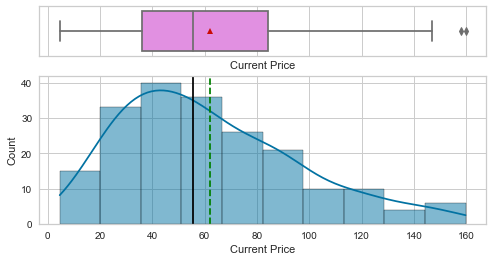

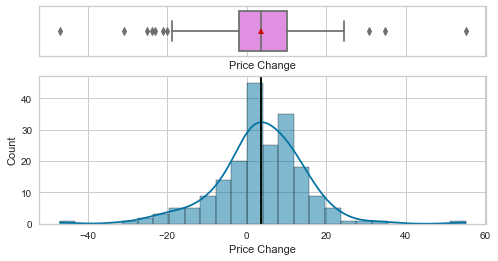

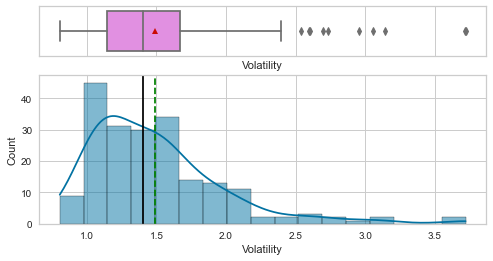

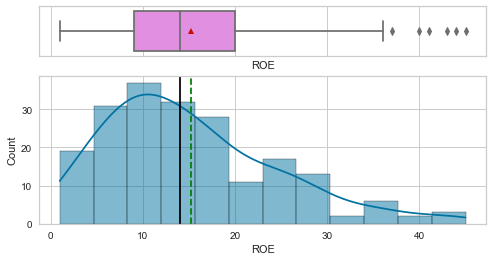

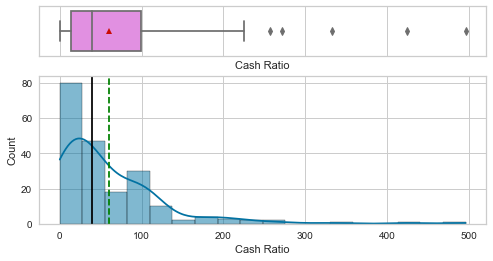

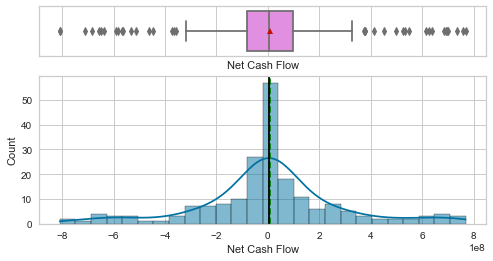

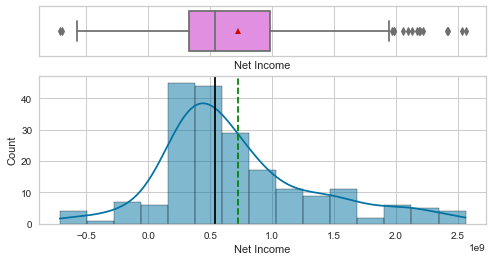

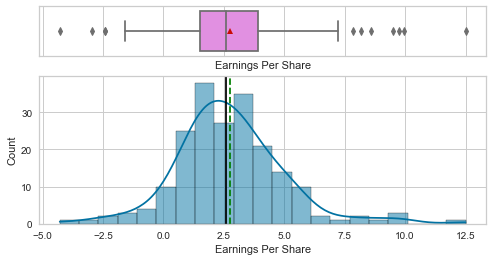

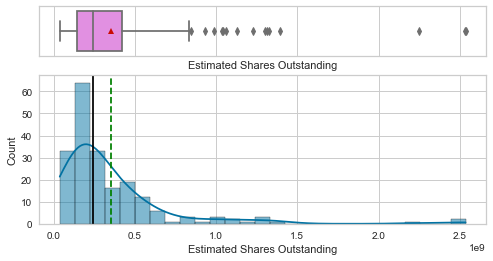

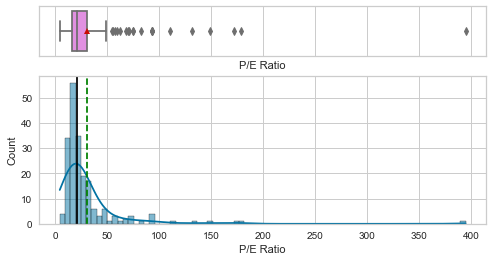

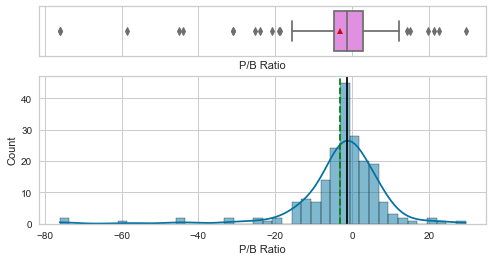

In [274]:
for item in num_col:
    histogram_boxplot(df3, item, kde=True, figsize=(8, 4))

In [275]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 3 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 201 non-null    object 
 1   Security                      201 non-null    object 
 2   GICS Sector                   201 non-null    object 
 3   GICS Sub Industry             201 non-null    object 
 4   Current Price                 201 non-null    float64
 5   Price Change                  201 non-null    float64
 6   Volatility                    201 non-null    float64
 7   ROE                           201 non-null    int64  
 8   Cash Ratio                    201 non-null    int64  
 9   Net Cash Flow                 201 non-null    int64  
 10  Net Income                    201 non-null    int64  
 11  Earnings Per Share            201 non-null    float64
 12  Estimated Shares Outstanding  201 non-null    float64
 13  P/E R

I have removed some extreme outliers from Current Price ROE, Net Income and Net Cash Flow columns. I have now set of 201 entries. I will repeat hierarchical clustering first.

In [333]:
datanew=df3.copy()

###  Note: instead of 350+ data we have now 200+ rows (and I did not reomve all outliers.).

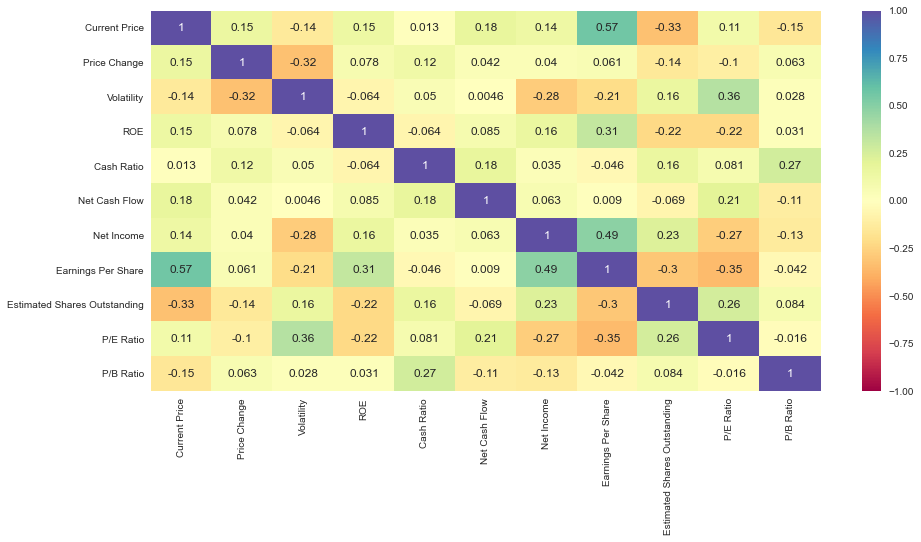

In [277]:
plt.figure(figsize=(15,7))
sns.heatmap(datanew.corr(),annot=True,vmin=-1,vmax=1,cmap="Spectral")
plt.show()

It seems with outlier removed the correlaiton of features has changed a bit. That means we really have a diferent data set and a different problem to study. I will check how the methods performnow. 

In [278]:
datagroupsectornew = datanew.groupby(['GICS Sector'])

In [279]:
datagroupsectornew.mean()

Current Price  Price Change  Volatility  \
GICS Sector                                                            
Consumer Discretionary           58.453200      5.757015    1.621013   
Consumer Staples                 65.510000     10.698998    1.164696   
Energy                           44.652501    -18.579480    2.821259   
Financials                       52.982580      2.554068    1.327445   
Health Care                      93.095500      8.269746    1.501650   
Industrials                      59.939358      0.572875    1.538886   
Information Technology           61.428000      6.531634    1.700994   
Materials                        82.613637      6.757981    1.635325   
Real Estate                      64.020771      6.064506    1.217228   
Telecommunications Services      14.915000     -1.071012    1.774506   
Utilities                        50.866429      0.966054    1.112416   

                                   ROE  Cash Ratio  Net Cash Flow  \
GICS Sector                                                         
Consumer Discretionary       20.320000   34.680000  -1.148283e+08   
Consumer Staples             17.625000   45.750000   8.868100e+07   
Energy                        9.750000   36.625000   5.573938e+07   
Financials                   11.129032   97.645161   1.475997e+07   
Health Care                  15.650000   93.150000   9.649190e+07   
Industrials                  19.333333   33.939394  -3.663270e+07   
Information Technology       16.200000  125.450000   1.469365e+07   
Materials                    21.000000   39.909091   8.798727e+07   
Real Estate                  11.772727   45.500000  -2.121686e+07   
Telecommunications Services   4.500000  249.500000   1.260000e+08   
Utilities                     9.952381   11.380952   3.790929e+07   

                               Net Income  Earnings Per Share  \
GICS Sector                                                     
Consumer Discretionary       5.904373e+08            2.788800   
Consumer Staples             7.908305e+08            3.130000   
Energy                       9.268688e+07            1.082500   
Financials                   1.076714e+09            3.376129   
Health Care                  8.384397e+08            3.649000   
Industrials                  6.768324e+08            3.010909   
Information Technology       6.497560e+08            1.904500   
Materials                    6.316015e+08            3.508182   
Real Estate                  5.202653e+08            1.873636   
Telecommunications Services  3.410000e+08            0.645000   
Utilities                    8.921187e+08            2.534762   

                             Estimated Shares Outstanding  P/E Ratio  \
GICS Sector                                                            
Consumer Discretionary                       2.035764e+08  21.402226   
Consumer Staples                             2.679484e+08  24.624725   
Energy                                       6.159525e+08  98.062680   
Financials                                   4.012880e+08  17.759575   
Health Care                                  3.429565e+08  34.708839   
Industrials                                  2.593180e+08  18.554794   
Information Technology                       5.463768e+08  55.146627   
Materials                                    2.004543e+08  28.278105   
Real Estate                                  3.874810e+08  40.971162   
Telecommunications Services                  6.157791e+08  15.221519   
Utilities                                    3.664980e+08  18.920113   

                             P/B Ratio  
GICS Sector                             
Consumer Discretionary      -10.542145  
Consumer Staples             -6.028988  
Energy                        0.137805  
Financials                   -5.222001  
Health Care                  -0.769874  
Industrials                  -0.031790  
Information Technology        2.279565  
Materials                    -1.269338  
R

In [281]:
# Scaling the data set before clustering
scaler = StandardScaler()
subsetwo = datanew[num_col].copy()
subset_scaledwo = scaler.fit_transform(subsetwo)

In [282]:
# Creating a dataframe from the scaled data
scaledwo_df = pd.DataFrame(subset_scaledwo, columns=subsetwo.columns)

In [283]:
scaledwo_df

Current Price  Price Change  Volatility       ROE  Cash Ratio  \
0         0.942162      0.919480   -0.277912 -0.662202    1.714288   
1        -0.198252     -0.465858    0.427932 -0.128082    3.037518   
2        -0.748675     -1.358976    0.048437 -0.555378   -0.169876   
3        -0.555259     -0.115052   -0.757721 -0.662202   -0.673279   
4        -0.111141     -0.097755   -0.872183 -0.448554   -0.745193   
..             ...           ...         ...       ...         ...   
196      -1.517908      0.524835    0.768045 -1.089498   -0.500683   
197      -0.753990      0.659377   -0.671158  0.085565    0.319144   
198       1.197589      0.513696   -0.182304 -1.516793    0.563653   
199      -1.025658     -0.407196   -0.050850 -1.196322    0.549271   
200      -0.416767      1.156284    0.241172  1.794748    0.060251   

     Net Cash Flow  Net Income  Earnings Per Share  \
0        -0.880815   -0.148110           -0.665306   
1         1.099053   -0.040216           -1.089368   
2        -0.696204    1.806113            0.106931   
3         0.998913   -0.137775           -0.067157   
4         0.026357    2.131911            0.169425   
..             ...         ...                 ...   
196      -0.176273   -0.397388           -1.040266   
197       0.037397   -0.612129           -0.388551   
198       1.315857   -0.921420           -0.879569   
199      -0.178492   -0.661053           -0.692089   
200       0.945496   -0.613732           -0.924207   

     Estimated Shares Outstanding  P/E Ratio  P/B Ratio  
0                        0.404113   1.215489   0.590959  
1                        5.165481   4.077514   0.335722  
2                        0.727514  -0.500359   0.858986  
3                       -0.290418  -0.380272   0.191083  
4                        0.192384  -0.329871   0.003860  
..                            ...        ...        ...  
196                      2.116903  -0.141092   0.225513  
197                     -0.464070  -0.303471   0.585336  
198                     -0.443344   2.784844  -1.691990  
199                     -0.254259  -0.211599   0.244442  
200                      0.401079   1.102960   0.389638  

[201 rows x 11 columns]

Number of Clusters: 1 	Average Distortion: 2.971576718568612
Number of Clusters: 2 	Average Distortion: 2.8246761669479894
Number of Clusters: 3 	Average Distortion: 2.636788658982894
Number of Clusters: 4 	Average Distortion: 2.5209000726422164
Number of Clusters: 5 	Average Distortion: 2.4600751842892046
Number of Clusters: 6 	Average Distortion: 2.389697433323229
Number of Clusters: 7 	Average Distortion: 2.3307873818210223
Number of Clusters: 8 	Average Distortion: 2.2617575962958876
Number of Clusters: 9 	Average Distortion: 2.181041266048433
Number of Clusters: 10 	Average Distortion: 2.1563867118127438
Number of Clusters: 11 	Average Distortion: 2.103742972207272
Number of Clusters: 12 	Average Distortion: 2.045867502936106
Number of Clusters: 13 	Average Distortion: 1.9954074989030997
Number of Clusters: 14 	Average Distortion: 1.9787841567506144
Number of Clusters: 15 	Average Distortion: 1.936629763353764


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

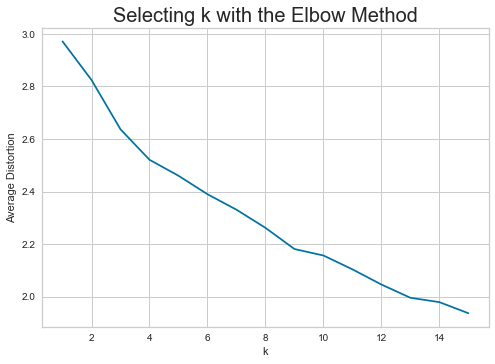

In [284]:
clusters = range(1, 16)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(scaledwo_df)
    prediction = model.predict(scaledwo_df)
    distortion = (
        sum(
            np.min(cdist(scaledwo_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / scaledwo_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

Elbow method suggests 4,9and 13 clusters.

For n_clusters = 2, silhouette score is 0.4052743643865646
For n_clusters = 3, silhouette score is 0.13323701784477263
For n_clusters = 4, silhouette score is 0.14167495585225062
For n_clusters = 5, silhouette score is 0.13710813938661812
For n_clusters = 6, silhouette score is 0.1426594848609436
For n_clusters = 7, silhouette score is 0.13621333922715073
For n_clusters = 8, silhouette score is 0.14428803546871644
For n_clusters = 9, silhouette score is 0.1526033738508356
For n_clusters = 10, silhouette score is 0.14872931471332929
For n_clusters = 11, silhouette score is 0.11109522601120331
For n_clusters = 12, silhouette score is 0.13395814275579168
For n_clusters = 13, silhouette score is 0.1543312429520509
For n_clusters = 14, silhouette score is 0.12869482866685727
For n_clusters = 15, silhouette score is 0.12282531412974901
For n_clusters = 16, silhouette score is 0.11830893235543782
For n_clusters = 17, silhouette score is 0.1243390124902949
For n_clusters = 18, silhouette score

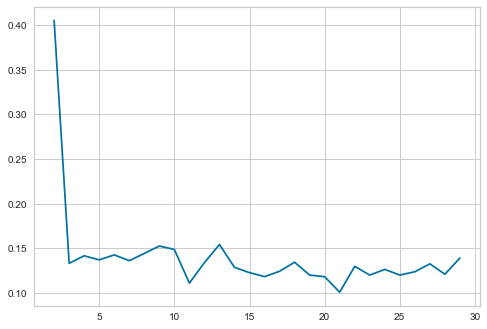

In [314]:
sil_score = []
cluster_list = list(range(2, 30))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((scaledwo_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(scaledwo_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

Maybe 8 clusters ? The silhouettes coefficint seems to be very small. 

Clluster profiling:

In [322]:
kmeansn8 = KMeans(n_clusters=8, random_state=0)
kmeansn8.fit(scaledwo_df)

KMeans(random_state=0)

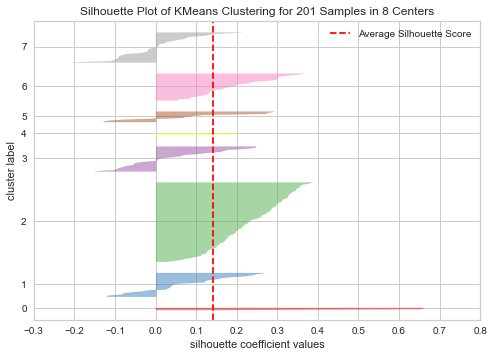

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 201 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [323]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(8, random_state=1))
visualizer.fit(scaledwo_df)
visualizer.show()

In [382]:
datanew8=datanew.copy()

In [383]:
scaledwo_new=scaledwo_df.copy()

In [384]:
# adding kmeans cluster labels to the original dataframe
datanew8["K_clust"] = kmeansn8.labels_

In [385]:
scaledwo_new["K_clust"] = kmeansn8.labels_

In [317]:
cluster_profile8n = datanew8.groupby("K_clust").mean()

In [338]:
cluster_profile8n["No"] = (
    datanew8.groupby("K_clust")["Current Price"].count().values
)

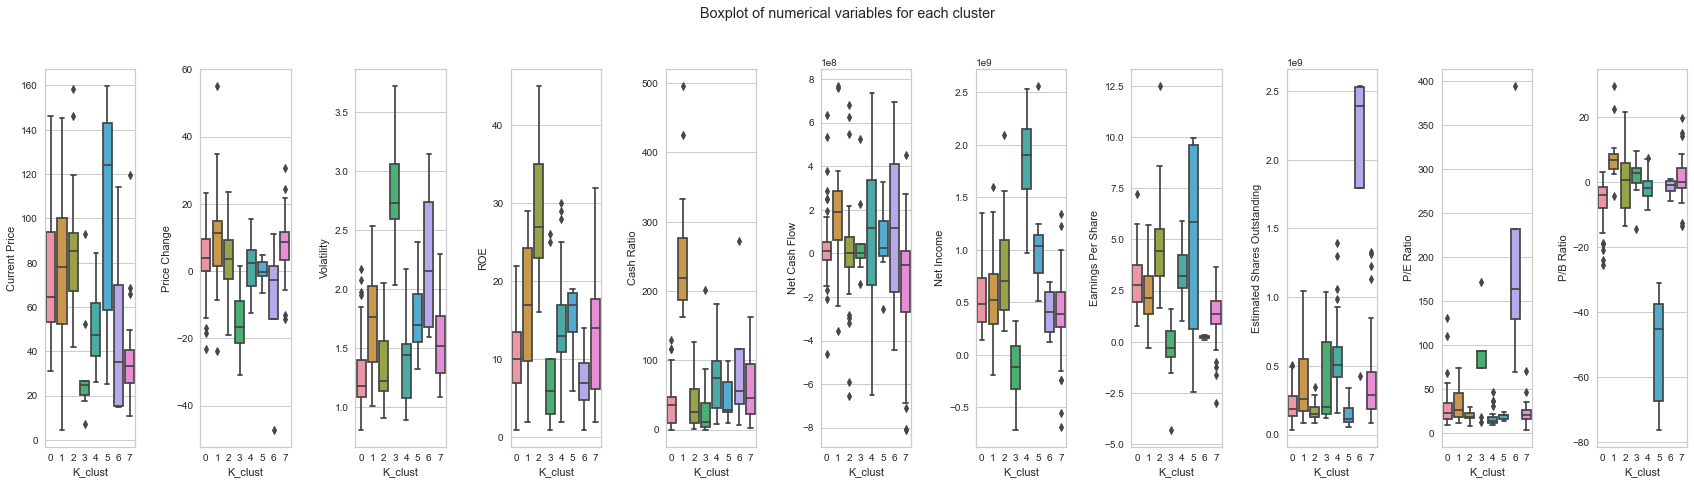

In [340]:
fig, axes = plt.subplots(1, 11, figsize=(24, 7))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(11):
    sns.boxplot(ax=axes[ii], y=datanew8[num_col[counter]], x=datanew8["K_clust"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [319]:
# lets display cluster profile
cluster_profile8n.style.highlight_max(color="lightgreen", axis=0)

### Conclusion - without outliers we get different sized with K-means clustering. 

Cluster 0 has 63 companies with data similar to average.

Cluster 1 has 12 companies with highes average P/B Ratio Net Cash Flow,Cash Ratio and Price Change (11%)

cluster 2 has 33 companies with highest average ROE. and negative average Net Cash flow and average P.B Ratio.

Cluster 3 has 9 companies with highest average volatility,lowest price. It is the only cluster that has negative average Earnings per Share. 
Since price is not high and the cluster has the biggest loss - due to -14% price change - this companies should be avoided.  

cluster 4 has 27 companies that have the highest average Net Income

Cluster 5 has 7 companies tand has the highest average price 102 dollars and highest earnigs per share.

Cluster 6 has 4 companies, and  highest average P/E ratio. Because of relatively high volatility and -10% price drop, smallest positive Earning per Share, 
it is probably better to avoid these companies as they seem overvalued. 

Cluster 7 has 46 companies with 2nd lowest average stock price. All of the other indexes are low. Not the lowest 
but this cluster seems to grop companies thatoverall donot perform well and it is reflected in low P/B Ratio, P/E Ratio, Earnings per Share.

## Conclusion: 
## For investments the companies in clusters 7 6 and 3 should be avoided. 

## One should pick companies from cluster 1,  cluster 2, cluster 5.




In [329]:
datanew8

Ticker Symbol                   Security             GICS Sector  \
3            ADBE          Adobe Systems Inc  Information Technology   
4             ADI       Analog Devices, Inc.  Information Technology   
5             ADM  Archer-Daniels-Midland Co        Consumer Staples   
7             AEE                Ameren Corp               Utilities   
8             AEP    American Electric Power               Utilities   
..            ...                        ...                     ...   
333           XRX                Xerox Corp.  Information Technology   
334           XYL                 Xylem Inc.             Industrials   
337           ZBH     Zimmer Biomet Holdings             Health Care   
338          ZION              Zions Bancorp              Financials   
339           ZTS                     Zoetis             Health Care   

                  GICS Sub Industry  Current Price  Price Change  Volatility  \
3              Application Software      93.940002     13.977195    1.357679   
4                    Semiconductors      55.320000     -1.827858    1.701169   
5             Agricultural Products      36.680000    -12.017268    1.516493   
7                    MultiUtilities      43.230000      2.174424    1.124186   
8                Electric Utilities      58.270000      2.371753    1.068485   
..                              ...            ...           ...         ...   
333  IT Consulting & Other Services      10.630000      9.474768    1.866680   
334        Industrial Conglomerates      36.500000     11.009729    1.166311   
337           Health Care Equipment     102.589996      9.347683    1.404206   
338                  Regional Banks      27.299999     -1.158588    1.468176   
339                 Pharmaceuticals      47.919998     16.678836    1.610285   

     ROE  Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
3      9         180     -240840000   629551000                1.26   
4     14         272      315120000   696878000                0.31   
5     10          49     -189000000  1849000000                2.99   
7      9          14      287000000   636000000                2.60   
8     11           9       13900000  2052300000                3.13   
..   ...         ...            ...         ...                 ...   
333    5          26      -43000000   474000000                0.42   
334   16          83       17000000   340000000                1.88   
337    1         100      376000000   147000000                0.78   
338    4          99      -43623000   309471000                1.20   
339   32          65      272000000   339000000                0.68   

     Estimated Shares Outstanding   P/E Ratio  P/B Ratio  K_clust  
3                    4.996437e+08   74.555557   4.199651        1  
4                    2.247994e+09  178.451613   1.059810        6  
5                    6.183946e+08   12.267559   7.496831        4  
7                    2.446154e+08   16.626923  -0.719497        0  
8                    4.218978e+08   18.456543  -3.022649        4  
..                            ...         ...        ...      ...  
333                  1.128571e+09   25.309524  -0.295949        7  
334                  1.808511e+08   19.414894   4.130471        7  
337                  1.884615e+08  131.525636 -23.884449        0  
338                  2.578925e+08   22.749999  -0.063096        7  
339                  4.985294e+08   70.470585   1.723068        7  

[201 rows x 16 columns]

## Companies from the clusters that one can recomend investing: 

### Cluster 1

In [330]:
print(datanew8.loc[datanew8['K_clust'] == 1])

    Ticker Symbol                          Security  \
3            ADBE                 Adobe Systems Inc   
14           AKAM           Akamai Technologies Inc   
32            APH                     Amphenol Corp   
36           AVGO                          Broadcom   
58           CELG                     Celgene Corp.   
118            EW              Edwards Lifesciences   
136          FSLR                   First Solar Inc   
137           FTR           Frontier Communications   
225           NEM  Newmont Mining Corp. (Hldg. Co.)   
283          SWKS                Skyworks Solutions   
293          TRIP                       TripAdvisor   
318           WAT                Waters Corporation   

                     GICS Sector                       GICS Sub Industry  \
3         Information Technology                    Application Software   
14        Information Technology            Internet Software & Services   
32        Information Technology                   Elect

### Cluster 2

In [331]:
print(datanew8.loc[datanew8['K_clust'] == 2])

    Ticker Symbol                           Security             GICS Sector  \
16            ALK               Alaska Air Group Inc             Industrials   
24            AMP               Ameriprise Financial              Financials   
29            AON                            Aon plc              Financials   
56            CCI   Crown Castle International Corp.             Real Estate   
63           CHRW           C. H. Robinson Worldwide             Industrials   
65             CI                        CIGNA Corp.             Health Care   
71            CMI                       Cummins Inc.             Industrials   
98            DOV                        Dover Corp.             Industrials   
99            DPS            Dr Pepper Snapple Group        Consumer Staples   
108           EMN                   Eastman Chemical               Materials   
120          EXPD                   Expeditors Int'l             Industrials   
130          FISV                       

### Cluster 5 

In [332]:
print(datanew8.loc[datanew8['K_clust'] == 5])

    Ticker Symbol                       Security             GICS Sector  \
22            AMG  Affiliated Managers Group Inc              Financials   
28           ANTM                    Anthem Inc.             Health Care   
69            CME                 CME Group Inc.              Financials   
93          DISCA     Discovery Communications-A  Consumer Discretionary   
94          DISCK     Discovery Communications-C  Consumer Discretionary   
121          EXPE                   Expedia Inc.  Consumer Discretionary   
321           WHR                Whirlpool Corp.  Consumer Discretionary   

                      GICS Sub Industry  Current Price  Price Change  \
22     Asset Management & Custody Banks     159.759995     -6.611335   
28                  Managed Health Care     139.440002     -0.620053   
69           Financial Exchanges & Data      90.599998     -2.402245   
93                    Cable & Satellite      26.680000      2.026769   
94                    Cable & S

I am curious how the hierarchical clustering would work for these data set with some outlier removed

### Hierarchical Clustering with some outliers removed

In [364]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]
high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(scaledwo_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(scaledwo_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.8640451721317667.
Cophenetic correlation for Euclidean distance and complete linkage is 0.6931709826459781.
Cophenetic correlation for Euclidean distance and average linkage is 0.8707478742762658.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.7374578594315708.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8517896621614677.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7027718766772754.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8441456442517208.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.7419582321823028.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8450684409804321.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5090047901831921.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8525641851203274.
Cophenetic co

In [365]:

 # printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)


Highest cophenetic correlation is 0.8707478742762658, which is obtained with Euclidean distance and average linkage.


In [366]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(scaledwo_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(scaledwo_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm


Cophenetic correlation for single linkage is 0.8640451721317667.
Cophenetic correlation for complete linkage is 0.6931709826459781.
Cophenetic correlation for average linkage is 0.8707478742762658.
Cophenetic correlation for centroid linkage is 0.8727819984063592.
Cophenetic correlation for ward linkage is 0.5168130341187935.
Cophenetic correlation for weighted linkage is 0.7374578594315708.


In [367]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8727819984063592, which is obtained with centroid linkage.


## Conclusion:Centroid linkage and Enclidean metric give the highest cophenetic correlation. But I think the ward linkage clusters look better (not like "outlier detection"). 

## Dendrograms:

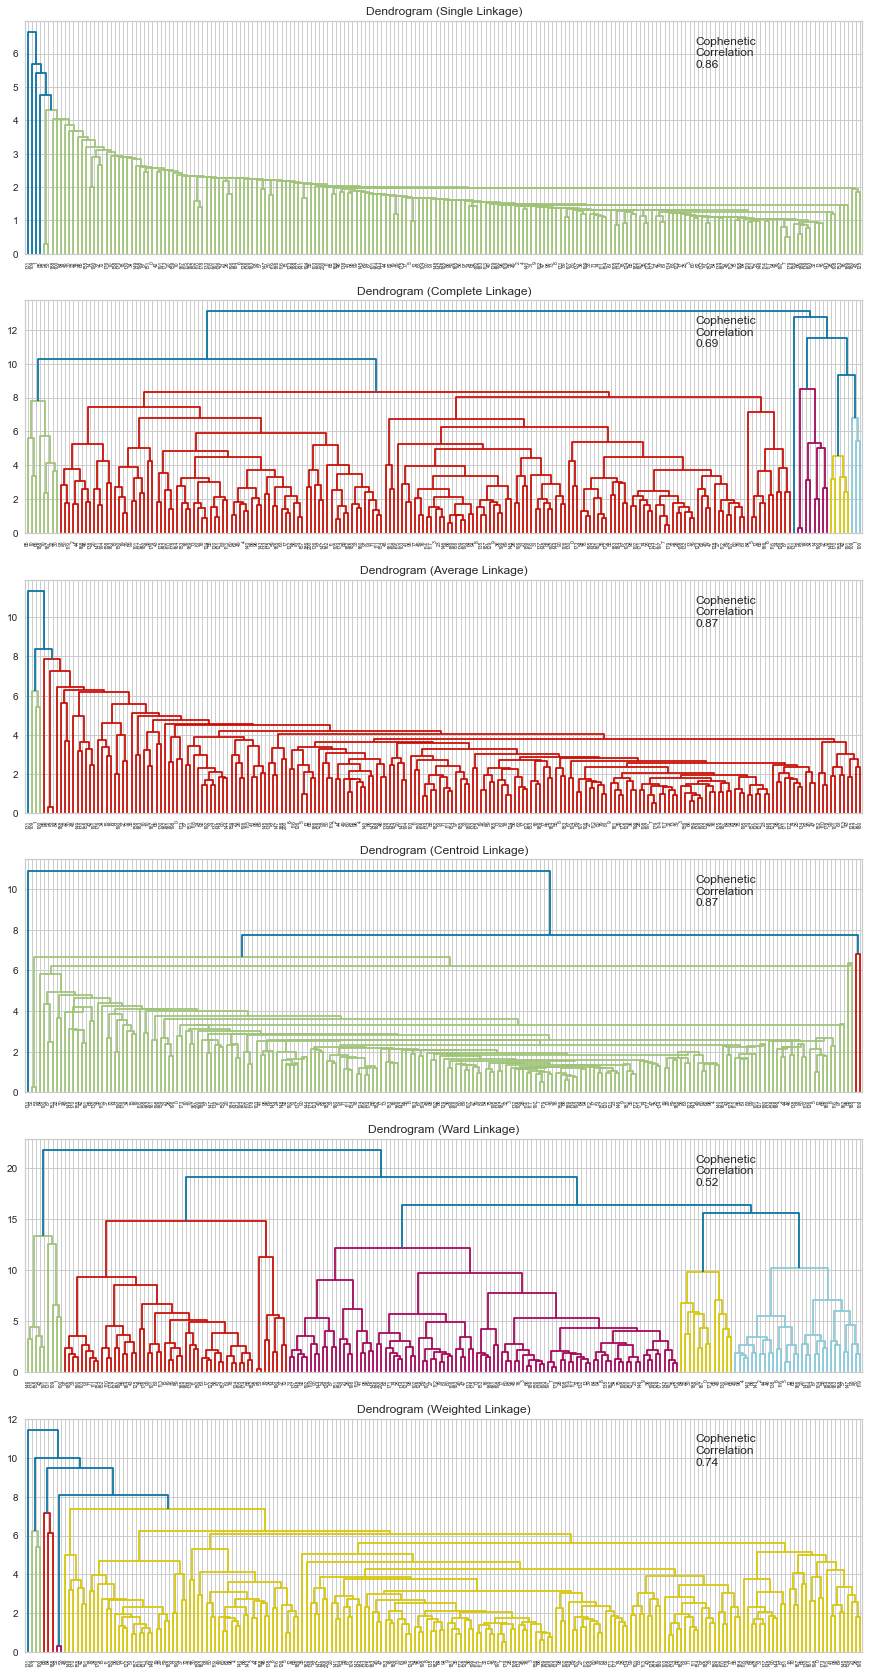

In [368]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(scaledwo_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(scaledwo_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

In [396]:
HCmodel8wo = AgglomerativeClustering(n_clusters=8, affinity="euclidean", linkage="ward")
HCmodel8wo.fit(scaledwo_df)

AgglomerativeClustering(n_clusters=8)

In [401]:
scaledhcwo=scaledwo_df.copy()

In [405]:
datawo8=subsetwo.copy()

In [406]:
datawo8["HC_Clusters"] = HCmodel8wo.labels_
scaledhcwo["HC_Clusters"] = HCmodel8wo.labels_

In [409]:
cluster_profile1wohc = datawo8.groupby("HC_Clusters").mean()

In [411]:
cluster_profile2wohc = scaledhcwo.groupby("HC_Clusters").mean()

In [412]:
cluster_profile1wohc["No_in_clust"] = (
    datawo8.groupby("HC_Clusters")["ROE"].count().values
)


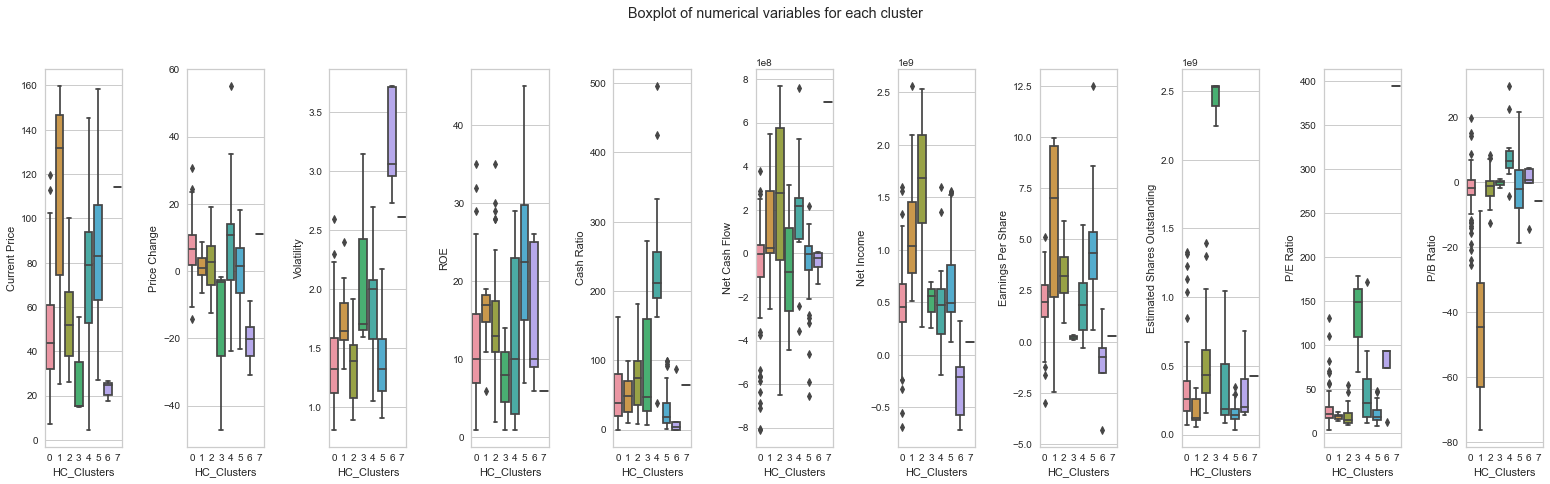

In [413]:
fig, axes = plt.subplots(1, 11, figsize=(22, 7))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(11):
    sns.boxplot(ax=axes[ii], y=datawo8[num_col[counter]], x=datawo8["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)


In [414]:

# lets display cluster profile
cluster_profile1wohc.style.highlight_max(color="lightgreen", axis=0)

## Conclusion: I do not see that agglomerative clustering performed better or worse than K-means clustering. Agglomerative clustering has found a cluster wiht 1 company so again it worked morelike outlier detector. 

## (Note: I have tried DBSCAN and the highest number of clusters I was getting with positive silhouette score  was 3 (for DBSCAN(eps=3, min_samples=2)) - so the DBSCAN was not working on our data, even on the data with partially removed outliers. I did not know how to continue with this so I do not include it here. )

## PCA 

In [417]:
scaledwo_new["K_clust"] = kmeansn8.labels_

In [420]:
# importing library
from sklearn.decomposition import PCA

# setting the number of components to 2
pca = PCA(n_components=9)

# transforming data and storing results in a dataframe
X_reduced_pca = pca.fit_transform(scaledwo_new)
reduced_df_pca = pd.DataFrame(
    data=X_reduced_pca, columns=["Component 1", "Component 2","Component 3", "Component 4", "Component 5", "Component 6", "Component 7", "Component 8","Component 9"]
)

In [423]:
# checking the amount of variance explained
pca.explained_variance_ratio_.sum()

0.9465900183829776

reduced_df_pca["K_clust"]=scaledwo_new["K_clust"]

### 9 componets PCA  explain 95% of infomration in the dataset. 

### Conclusion: These are a bit too many components to include. I do not think it helps for this project to replace 11 features with 9 PCA components. 

### 

## K-means vs Hierarchical Clustering

K- means seemed to perform bad but when I did hierarchical clustering the method worked like outlier "detector" by acicng most of the companies in one clster and the outliers each in separate cluster. 
The best cophenetic distance ws for Euclidean and average linkage method. But this method sufered from the "detecting outliers" 
behavior.

Dendrograms suggest that ward linkage hierarchical clustering can produce bigger clusters. So I have tried and indeed the clusters structure changed - and we have still one big cluster but the other clusters contain more than company. 

At the moment the data set serves more for detection of outliers and can be used to single out companies that have exceptionaly good and bed 
stock market results.



After removal of outliers the K-mean clustering produced clusters that have more decent sizes and one can connect cluster with 
distinct stock performance and use this for recomendation - both fromwhich clusters toselect the companies and from which clusters to avoid the companies at the moment.

## Actionable Insights and Recommendations


Hierarchical clustering can be used to quickly group companies and detect outliers for given feature  this can help to find best and worst performins company/companies. 

It seems that both methods did not work. I have tried to increase for K-means clustering the nmber of clusters to 20 and the 
it did not seem to work better with larger number of clusters.

One can see with dendrograms that for anything except ward linkage - the clusters that structure of dendrograms suggests that the "outlier detection" behavior would continue also for larger number of clusters. 

When designing investment portfolio it is useful to diversify. It means to invest in several companies stocks.

One cannot find a clear rules/suggestions for investing based on the companies performance and based on the 
indexes such as Ratios provided in the dataset.  It seems it is typical to present investing like a kind of 
"trade magic".

Machine Learning methods - for example clustering offers comparisons of the data for many variables. 
One an both study correlations and clustering of the stock market as a whoe or within industry sector. 

Machine Learning can help discover trends/correlations. This tpic has been studied in the past for many years and now it can be studied 
in real time as the new data is generatedevery day/month etc. 

Clustering offers grouping of the companies. When such grouping is done by hand one cannot easily decide what are 
the best ways to group companies. 


I have indentified 3 clusters of companies to avoid and 3 clusters of companies one can use to build portfolio.

One recomendation overall seem sot be to avoid the energy Sector. 

Instead invest in IT, Telecom Service, and Machine Learning - based businesses (please see the section where songle company sized clusters were discussed - I included the names of the companies).

## Other comment:
I think it would be interesting to study the indexes and other parameters provided by the companies ...if one cannot define 
better perfomance indicators or relative risk indicators (long and short term). 

We were provided data that do not reflect dynamics of the stock market. And that is a second topic - how the parameters/indices 
related to companies performance can be mapped onto their stocks. 

It has been known that disasters, major events, news-twitter-"rumours" also can afect the stock market. In the project here in the first part with outliers - the clustering served as outler detection. It could maybe serve as 
a way to detect stock market manipulations.  
